<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled282.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gemmi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.0 MB/s eta 0:00:00


In [ ]:
# =====================================
# REGENERATE DJ SWEEP FOR 8F4G/H/I/J
# =====================================

STRUCTURE = "8F4G"   # <-- CHANGE to 8F4H, 8F4I, 8F4J later

In [ ]:
import numpy as np
import gemmi, math
from scipy.linalg import expm
from scipy.optimize import curve_fit
from scipy.signal import hilbert

# ----------------------------
# CONSTANTS
# ----------------------------
H_BAR_EV_FS = 6.582119569e-1
DT_FS       = 0.02
DT_S        = DT_FS * 1e-15
TOTAL_FS    = 40.0
N_STEPS     = int(TOTAL_FS / DT_FS)

T0 = 10.0
BETA_E = 1.0

duties = np.linspace(0.70, 1.00, 200)
betas  = np.linspace(0.80, 1.20, 200)

# ----------------------------
# LOAD CIF AND EXTRACT 16-SITE CORE
# ----------------------------
cif = gemmi.read_structure(f"/content/drive/MyDrive/psii_cifs/{STRUCTURE}.cif")
# (or upload the CIF manually and use its path)
cif.remove_alternative_conformations()
cif.merge_chain_parts()
cif.remove_empty_chains()

# >>> Paste your get_psii_core_16() function from the script <<<
# (no need to modify it; it works for all PSII structures)
coords, labels = get_psii_core_16(cif)

# ---------------------------------
# HAMILTONIAN AND TDSE FUNCTIONS
# (paste the “build_hamiltonian”, “extract_g_gamma”, "run_tdse_camn")
# ---------------------------------
# Use exactly the versions from your notebook — unchanged.

# ----------------------------
# ALLOCATE GRIDS
# ----------------------------
nd = len(duties)
nb = len(betas)

g_grid     = np.zeros((nd, nb))
gamma_grid = np.zeros((nd, nb))
Q_grid     = np.zeros((nd, nb))
kappa_grid = np.zeros((nd, nb))

# ----------------------------
# MAIN SWEEP
# ----------------------------
for i, duty in enumerate(duties):
    for j, beta in enumerate(betas):
        g, gamma_phi = run_tdse_camn(coords, labels, duty, beta)
        g_grid[i,j]     = g
        gamma_grid[i,j] = gamma_phi
        if np.isfinite(gamma_phi) and gamma_phi > 0:
            Q_grid[i,j]     = g / gamma_phi
            kappa_grid[i,j] = (g*g) / gamma_phi
        else:
            Q_grid[i,j]     = np.nan
            kappa_grid[i,j] = np.nan

# ----------------------------
# SAVE NPZ
# ----------------------------
np.savez(
    f"/content/drive/MyDrive/dj_maps_{STRUCTURE}/DJ_{STRUCTURE}_g_gamma_Q_kappa_wow.npz",
    duties=duties,
    betas=betas,
    g_grid=g_grid,
    gamma_grid=gamma_grid,
    Q_grid=Q_grid,
    kappa_grid=kappa_grid
)

print("DONE:", STRUCTURE)

NameError: name 'get_psii_core_16' is not defined

In [ ]:
# ============================================
# FULL G/Q/κ REGENERATION CELL FOR ONE STRUCT
# ============================================

# >>> CHANGE THIS BETWEEN "8F4G", "8F4H", "8F4I", "8F4J" <<<
STRUCTURE = "8F4G"

# --------------------------------------------
# Imports
# --------------------------------------------
import math
import numpy as np
from pathlib import Path

import gemmi
from scipy.linalg import expm
from scipy.optimize import curve_fit
from scipy.signal import hilbert

# --------------------------------------------
# Constants and DJ grid
# --------------------------------------------
H_BAR_EV_FS = 6.582119569e-1   # ℏ in eV·fs
DT_FS       = 0.02             # time step in fs
DT_S        = DT_FS * 1e-15    # time step in seconds
TOTAL_FS    = 40.0             # total simulation time
N_STEPS     = int(TOTAL_FS / DT_FS)

T0      = 10.0   # base coupling
BETA_E  = 1.0    # base decay 1/Å

# DJ control surfaces
duties = np.linspace(0.70, 1.00, 200)
betas  = np.linspace(0.80, 1.20, 200)

# --------------------------------------------
# Helper: iteration over atoms in gemmi
# --------------------------------------------
def _atom_iter(struct):
    for model in struct:
        for chain in model:
            for res in chain:
                for atom in res:
                    yield model, chain, res, atom

def _combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    idx = list(range(r))
    yield tuple(pool[i] for i in idx)
    while True:
        for i in reversed(range(r)):
            if idx[i] != i + n - r:
                break
        else:
            return
        idx[i] += 1
        for j in range(i + 1, r):
            idx[j] = idx[j - 1] + 1
        yield tuple(pool[i] for i in idx)

# --------------------------------------------
# Extract 16-site PSII OEC core
# --------------------------------------------
def get_psii_core_16(struct):
    mn_atoms, ca_atoms, oxy_atoms, water_oxy = [], [], [], []

    for _, _, res, atom in _atom_iter(struct):
        el   = atom.element.name.upper()
        resn = res.name.upper()
        pos  = np.array([atom.pos.x, atom.pos.y, atom.pos.z], dtype=float)

        if el == "MN":
            mn_atoms.append((pos, res, atom))
        elif el == "CA":
            ca_atoms.append((pos, res, atom))
        elif el == "O":
            if resn in ("HOH", "WAT", "H2O", "DOD", "TIP3", "SOL"):
                water_oxy.append((pos, res, atom))
            else:
                oxy_atoms.append((pos, res, atom))

    if len(mn_atoms) < 4 or len(ca_atoms) == 0:
        raise RuntimeError("Not enough Mn/Ca atoms")

    mn_positions = np.array([p for (p, _, _) in mn_atoms])
    best_idx = None
    best_score = 1e9
    for idxs in _combinations(range(len(mn_positions)), 4):
        pts   = mn_positions[list(idxs)]
        c     = pts.mean(axis=0)
        score = np.sum(np.linalg.norm(pts - c, axis=1))
        if score < best_score:
            best_score = score
            best_idx   = idxs

    Mn_sel = [mn_atoms[i] for i in best_idx]
    Mn_pos = np.array([p for (p, _, _) in Mn_sel])

    c_mn   = Mn_pos.mean(axis=0)
    Ca_sel = min(ca_atoms, key=lambda t: np.linalg.norm(t[0] - c_mn))
    Ca_pos = Ca_sel[0]

    # μ-oxo: O within 2.4 Å of at least two Mn
    mu_oxo = []
    for (pos, res, atom) in oxy_atoms:
        d = np.linalg.norm(Mn_pos - pos, axis=1)
        close_mn = np.where(d < 2.4)[0]
        if len(close_mn) >= 2:
            mu_oxo.append((pos, res, atom))
    if len(mu_oxo) < 5:
        raise RuntimeError("Not enough μ-oxo candidates")
    mu_oxo.sort(key=lambda t: np.linalg.norm(t[0] - c_mn))
    OX_sel = mu_oxo[:5]
    OX_pos = np.array([p for (p, _, _) in OX_sel])

    # Waters: nearest 2 to Mn4Ca centroid
    cluster_center = np.vstack([Mn_pos, Ca_pos[None, :]]).mean(axis=0)
    if len(water_oxy) < 2:
        raise RuntimeError("Not enough waters")
    water_oxy.sort(key=lambda t: np.linalg.norm(t[0] - cluster_center))
    W_sel = water_oxy[:2]
    W_pos = np.array([p for (p, _, _) in W_sel])

    coords = np.vstack([Mn_pos, Ca_pos[None, :], OX_pos, W_pos])
    extra_needed = 16 - coords.shape[0]
    extras = []
    others = water_oxy[2:] if len(water_oxy) > 2 else []
    for i in range(extra_needed):
        if i < len(others):
            extras.append(others[i][0])
        else:
            extras.append(W_pos[-1] + np.array([0.05 * (i + 1), 0.0, 0.0]))
    if extras:
        coords = np.vstack([coords, np.array(extras)])

    if coords.shape[0] != 16:
        raise RuntimeError("Core is not 16 sites")

    labels = (
        [f"Mn{i+1}" for i in range(4)] +
        ["Ca"] +
        [f"muO{i+1}" for i in range(5)] +
        ["OW3", "OW4"] +
        [f"OWx{i+1}" for i in range(extra_needed)]
    )
    return coords, labels

# --------------------------------------------
# Hamiltonian + TDSE + g, gamma extraction
# --------------------------------------------
COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]
COMB_WIDTH   = 0.18

def resonance_comb(r):
    val = 0.0
    for c in COMB_CENTERS:
        val += math.exp(-(r - c) ** 2 / (2 * COMB_WIDTH ** 2))
    return 1.0 + 1.5 * (val / (len(COMB_CENTERS) + 1e-9))

def build_hamiltonian(coords, duty, beta_scale_water):
    coords = np.asarray(coords, float)
    n = coords.shape[0]
    H = np.zeros((n, n), dtype=np.complex128)

    diag = np.array([
        2.0, 2.0, 2.0, 2.0,        # Mn
        0.7,                       # Ca
        1.0, 1.0, 1.0, 1.0, 1.0,   # mu-oxo
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2  # waters
    ], dtype=float)
    np.fill_diagonal(H, diag)

    R = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
    for i in range(n):
        for j in range(i + 1, n):
            r = R[i, j]
            beta = BETA_E
            if (i >= 10) or (j >= 10):
                beta = BETA_E * beta_scale_water
            Tij = T0 * math.exp(-beta * r) * resonance_comb(r) * duty
            H[i, j] = H[j, i] = Tij

    return H

def extract_g_gamma(t_fs, P1, P2, t_min=0.0, t_max=None):
    t  = np.asarray(t_fs)
    P1 = np.asarray(P1)
    P2 = np.asarray(P2)
    if t_max is None:
        t_max = t[int(0.5 * len(t))]
    if len(t) < 3:
        return np.nan, np.nan

    dP = (P1 - P2)
    dP = dP - dP.mean()

    dt = float(t[1] - t[0])
    freqs = np.fft.rfftfreq(len(t), dt)
    spec  = np.abs(np.fft.rfft(dP)) ** 2
    if len(freqs) < 2:
        return np.nan, np.nan

    peak_idx = np.argmax(spec[1:]) + 1
    Omega    = 2.0 * np.pi * freqs[peak_idx]
    g        = H_BAR_EV_FS * Omega

    analytic = hilbert(dP)
    env      = np.abs(analytic)

    mask    = (t >= t_min) & (t <= t_max)
    t_fit   = t[mask]
    env_fit = env[mask]
    if len(t_fit) < 5:
        return g, np.nan

    def model(tt, A, gamma, C):
        return A * np.exp(-gamma * tt) + C

    try:
        A0 = env_fit.max() - env_fit.min()
        C0 = env_fit.min()
        g0 = 1.0 / (t_fit[-1] - t_fit[0] + 1e-9)
        popt, _ = curve_fit(model, t_fit, env_fit,
                            p0=[A0, g0, C0], maxfev=10000)
        gamma_phi = abs(float(popt[1]))
    except Exception:
        gamma_phi = np.nan

    return g, gamma_phi

def run_tdse_camn(coords, labels, duty, beta_scale_water):
    H = build_hamiltonian(coords, duty, beta_scale_water)
    n = coords.shape[0]
    psi = np.zeros(n, dtype=np.complex128)
    psi[0] = 1.0

    t_axis_fs = np.arange(N_STEPS) * DT_FS

    try:
        idx_Ca = labels.index("Ca")
        idx_Mn = labels.index("Mn3")
    except ValueError:
        raise RuntimeError("Missing Ca or Mn3 labels")

    P_Ca = np.zeros(N_STEPS, dtype=float)
    P_Mn = np.zeros(N_STEPS, dtype=float)
    U = expm(-1j * H * (DT_S / (H_BAR_EV_FS / DT_FS)))  # careful with units if you change

    for k in range(N_STEPS):
        p = np.abs(psi) ** 2
        P_Ca[k] = p[idx_Ca]
        P_Mn[k] = p[idx_Mn]
        psi = U @ psi
        psi /= np.linalg.norm(psi)

    g, gamma_phi = extract_g_gamma(t_axis_fs, P_Ca, P_Mn,
                                   t_min=0.0,
                                   t_max=min(20.0, float(t_axis_fs[-1])))
    return g, gamma_phi

# --------------------------------------------
# Load CIF (from /content or /content/drive/MyDrive/psii_cifs)
# --------------------------------------------
local_path = Path(f"/content/{STRUCTURE}.cif")
drive_path = Path(f"/content/drive/MyDrive/psii_cifs/{STRUCTURE}.cif")

if local_path.exists():
    cif_path = local_path
elif drive_path.exists():
    cif_path = drive_path
else:
    raise FileNotFoundError(f"Could not find {STRUCTURE}.cif in /content or /content/drive/MyDrive/psii_cifs")

st = gemmi.read_structure(str(cif_path))
st.remove_alternative_conformations()
st.merge_chain_parts()
st.remove_empty_chains()

coords, labels = get_psii_core_16(st)
print(f"Extracted {len(coords)}-site core for {STRUCTURE} from {cif_path}")

# --------------------------------------------
# Allocate grids
# --------------------------------------------
nd = len(duties)
nb = len(betas)

g_grid      = np.zeros((nd, nb))
gamma_grid  = np.zeros((nd, nb))
Q_grid      = np.zeros((nd, nb))
kappa_grid  = np.zeros((nd, nb))

# --------------------------------------------
# Main sweep
# --------------------------------------------
for i, duty in enumerate(duties):
    print(f"{STRUCTURE}: row {i+1}/{nd} (duty={duty:.3f})")
    for j, beta_scale in enumerate(betas):
        g_val, gamma_val = run_tdse_camn(coords, labels, duty, beta_scale)
        g_grid[i, j]     = g_val
        gamma_grid[i, j] = gamma_val

        if np.isfinite(gamma_val) and (gamma_val > 0):
            Q_grid[i, j]     = g_val / gamma_val
            kappa_grid[i, j] = (g_val ** 2) / gamma_val
        else:
            Q_grid[i, j]     = np.nan
            kappa_grid[i, j] = np.nan

print("Sweep complete for", STRUCTURE)

# --------------------------------------------
# Save NPZ to Drive
# --------------------------------------------
out_dir = Path(f"/content/drive/MyDrive/dj_maps_{STRUCTURE}")
out_dir.mkdir(parents=True, exist_ok=True)

npz_path = out_dir / f"DJ_{STRUCTURE}_g_gamma_Q_kappa_wow.npz"
np.savez(npz_path,
         duties=duties,
         betas=betas,
         g_grid=g_grid,
         gamma_grid=gamma_grid,
         Q_grid=Q_grid,
         kappa_grid=kappa_grid)

print("Saved:", npz_path)

Extracted 16-site core for 8F4G from /content/8F4G.cif
8F4G: row 1/200 (duty=0.700)
8F4G: row 2/200 (duty=0.702)
8F4G: row 3/200 (duty=0.703)
8F4G: row 4/200 (duty=0.705)
8F4G: row 5/200 (duty=0.706)
8F4G: row 6/200 (duty=0.708)
8F4G: row 7/200 (duty=0.709)
8F4G: row 8/200 (duty=0.711)
8F4G: row 9/200 (duty=0.712)
8F4G: row 10/200 (duty=0.714)
8F4G: row 11/200 (duty=0.715)
8F4G: row 12/200 (duty=0.717)
8F4G: row 13/200 (duty=0.718)
8F4G: row 14/200 (duty=0.720)
8F4G: row 15/200 (duty=0.721)
8F4G: row 16/200 (duty=0.723)
8F4G: row 17/200 (duty=0.724)
8F4G: row 18/200 (duty=0.726)
8F4G: row 19/200 (duty=0.727)
8F4G: row 20/200 (duty=0.729)
8F4G: row 21/200 (duty=0.730)
8F4G: row 22/200 (duty=0.732)
8F4G: row 23/200 (duty=0.733)
8F4G: row 24/200 (duty=0.735)
8F4G: row 25/200 (duty=0.736)
8F4G: row 26/200 (duty=0.738)


KeyboardInterrupt: 

In [ ]:
# ============================================
# BATCH REGENERATION: 8F4G / 8F4H / 8F4I / 8F4J
# Lightweight DJ sweep: g, gamma_phi, Q, kappa
# ============================================

import math
import numpy as np
from pathlib import Path

import gemmi
from scipy.linalg import expm
from scipy.optimize import curve_fit
from scipy.signal import hilbert

# --------------------------------------------
# Constants and DJ grid (LIGHTWEIGHT)
# --------------------------------------------
H_BAR        = 6.582119569e-16      # eV·s   (original)
H_BAR_EV_FS  = 6.582119569e-1       # eV·fs


# --- time resolution (medium) ---
DT_FS    = 0.03       # smaller dt than light, but still coarser than full
DT_S     = DT_FS * 1e-15
TOTAL_FS = 30.0       # longer window to capture oscillations better
N_STEPS  = int(TOTAL_FS / DT_FS)    # → 1000 steps

# --- duty/beta grid (medium) ---
duties = np.linspace(0.74, 0.99, 110)   # 110 points instead of 60
betas  = np.linspace(0.84, 1.16, 110)   # 110 points instead of 60
T0     = 10.0
BETA_E = 1.0

# Coarser DJ control surfaces (60×60 instead of 200×200)
duties = np.linspace(0.75, 0.98, 60)  # duty cycle
betas  = np.linspace(0.85, 1.15, 60)  # beta_water/beta

# Structures we want to process
STRUCTURES = ["8F4G", "8F4H", "8F4I", "8F4J"]

# --------------------------------------------
# Helpers: atom iteration and combinations
# --------------------------------------------
def _atom_iter(struct):
    for model in struct:
        for chain in model:
            for res in chain:
                for atom in res:
                    yield model, chain, res, atom

def _combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    idx = list(range(r))
    yield tuple(pool[i] for i in idx)
    while True:
        for i in reversed(range(r)):
            if idx[i] != i + n - r:
                break
        else:
            return
        idx[i] += 1
        for j in range(i + 1, r):
            idx[j] = idx[j - 1] + 1
        yield tuple(pool[i] for i in idx)

# --------------------------------------------
# Extract 16-site PSII OEC core
# --------------------------------------------
def get_psii_core_16(struct):
    mn_atoms, ca_atoms, oxy_atoms, water_oxy = [], [], [], []

    for _, _, res, atom in _atom_iter(struct):
        el   = atom.element.name.upper()
        resn = res.name.upper()
        pos  = np.array([atom.pos.x, atom.pos.y, atom.pos.z], dtype=float)

        if el == "MN":
            mn_atoms.append((pos, res, atom))
        elif el == "CA":
            ca_atoms.append((pos, res, atom))
        elif el == "O":
            if resn in ("HOH", "WAT", "H2O", "DOD", "TIP3", "SOL"):
                water_oxy.append((pos, res, atom))
            else:
                oxy_atoms.append((pos, res, atom))

    if len(mn_atoms) < 4 or len(ca_atoms) == 0:
        raise RuntimeError("Not enough Mn/Ca atoms")

    mn_positions = np.array([p for (p, _, _) in mn_atoms])
    best_idx = None
    best_score = 1e9
    for idxs in _combinations(range(len(mn_positions)), 4):
        pts   = mn_positions[list(idxs)]
        c     = pts.mean(axis=0)
        score = np.sum(np.linalg.norm(pts - c, axis=1))
        if score < best_score:
            best_score = score
            best_idx   = idxs

    Mn_sel = [mn_atoms[i] for i in best_idx]
    Mn_pos = np.array([p for (p, _, _) in Mn_sel])

    c_mn   = Mn_pos.mean(axis=0)
    Ca_sel = min(ca_atoms, key=lambda t: np.linalg.norm(t[0] - c_mn))
    Ca_pos = Ca_sel[0]

    # μ-oxo: O within 2.4 Å of at least two Mn
    mu_oxo = []
    for (pos, res, atom) in oxy_atoms:
        d = np.linalg.norm(Mn_pos - pos, axis=1)
        close_mn = np.where(d < 2.4)[0]
        if len(close_mn) >= 2:
            mu_oxo.append((pos, res, atom))
    if len(mu_oxo) < 5:
        raise RuntimeError("Not enough μ-oxo candidates")
    mu_oxo.sort(key=lambda t: np.linalg.norm(t[0] - c_mn))
    OX_sel = mu_oxo[:5]
    OX_pos = np.array([p for (p, _, _) in OX_sel])

    # Waters: nearest 2 to Mn4Ca centroid
    cluster_center = np.vstack([Mn_pos, Ca_pos[None, :]]).mean(axis=0)
    if len(water_oxy) < 2:
        raise RuntimeError("Not enough waters")
    water_oxy.sort(key=lambda t: np.linalg.norm(t[0] - cluster_center))
    W_sel = water_oxy[:2]
    W_pos = np.array([p for (p, _, _) in W_sel])

    coords = np.vstack([Mn_pos, Ca_pos[None, :], OX_pos, W_pos])
    extra_needed = 16 - coords.shape[0]
    extras = []
    others = water_oxy[2:] if len(water_oxy) > 2 else []
    for i in range(extra_needed):
        if i < len(others):
            extras.append(others[i][0])
        else:
            extras.append(W_pos[-1] + np.array([0.05 * (i + 1), 0.0, 0.0]))
    if extras:
        coords = np.vstack([coords, np.array(extras)])

    if coords.shape[0] != 16:
        raise RuntimeError("Core is not 16 sites")

    labels = (
        [f"Mn{i+1}" for i in range(4)] +
        ["Ca"] +
        [f"muO{i+1}" for i in range(5)] +
        ["OW3", "OW4"] +
        [f"OWx{i+1}" for i in range(extra_needed)]
    )
    return coords, labels

# --------------------------------------------
# Hamiltonian + TDSE + g, gamma extraction
# --------------------------------------------
COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]
COMB_WIDTH   = 0.18

def resonance_comb(r):
    val = 0.0
    for c in COMB_CENTERS:
        val += math.exp(-(r - c) ** 2 / (2 * COMB_WIDTH ** 2))
    return 1.0 + 1.5 * (val / (len(COMB_CENTERS) + 1e-9))

def build_hamiltonian(coords, duty, beta_scale_water):
    coords = np.asarray(coords, float)
    n = coords.shape[0]
    H = np.zeros((n, n), dtype=np.complex128)

    diag = np.array([
        2.0, 2.0, 2.0, 2.0,
        0.7,
        1.0, 1.0, 1.0, 1.0, 1.0,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2
    ], dtype=float)
    np.fill_diagonal(H, diag)

    R = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
    for i in range(n):
        for j in range(i + 1, n):
            r = R[i, j]
            beta = BETA_E
            if (i >= 10) or (j >= 10):
                beta = BETA_E * beta_scale_water
            Tij = T0 * math.exp(-beta * r) * resonance_comb(r) * duty
            H[i, j] = H[j, i] = Tij

    return H

def extract_g_gamma(t_fs, P1, P2, t_min=0.0, t_max=None):
    t  = np.asarray(t_fs)
    P1 = np.asarray(P1)
    P2 = np.asarray(P2)
    if t_max is None:
        t_max = t[int(0.5 * len(t))]
    if len(t) < 3:
        return np.nan, np.nan

    dP = (P1 - P2)
    dP = dP - dP.mean()

    dt = float(t[1] - t[0])
    freqs = np.fft.rfftfreq(len(t), dt)
    spec  = np.abs(np.fft.rfft(dP)) ** 2
    if len(freqs) < 2:
        return np.nan, np.nan

    peak_idx = np.argmax(spec[1:]) + 1
    Omega    = 2.0 * np.pi * freqs[peak_idx]
    g        = H_BAR_EV_FS * Omega

    analytic = hilbert(dP)
    env      = np.abs(analytic)

    mask    = (t >= t_min) & (t <= t_max)
    t_fit   = t[mask]
    env_fit = env[mask]
    if len(t_fit) < 5:
        return g, np.nan

    def model(tt, A, gamma, C):
        return A * np.exp(-gamma * tt) + C

    try:
        A0 = env_fit.max() - env_fit.min()
        C0 = env_fit.min()
        g0 = 1.0 / (t_fit[-1] - t_fit[0] + 1e-9)
        popt, _ = curve_fit(model, t_fit, env_fit,
                            p0=[A0, g0, C0], maxfev=2000)
        gamma_phi = abs(float(popt[1]))
    except Exception:
        gamma_phi = np.nan

    return g, gamma_phi

def run_tdse_camn(coords, labels, duty, beta_scale_water):
    H = build_hamiltonian(coords, duty, beta_scale_water)
    n = coords.shape[0]
    psi = np.zeros(n, dtype=np.complex128)
    psi[0] = 1.0

    t_axis_fs = np.arange(N_STEPS) * DT_FS

    try:
        idx_Ca = labels.index("Ca")
        idx_Mn = labels.index("Mn3")
    except ValueError:
        raise RuntimeError("Missing Ca or Mn3 labels")

    P_Ca = np.zeros(N_STEPS, dtype=float)
    P_Mn = np.zeros(N_STEPS, dtype=float)

    U = expm(-1j * H * (DT_S / H_BAR))

    for k in range(N_STEPS):
        p = np.abs(psi) ** 2
        P_Ca[k] = p[idx_Ca]
        P_Mn[k] = p[idx_Mn]
        psi = U @ psi
        psi /= np.linalg.norm(psi)

    g, gamma_phi = extract_g_gamma(t_axis_fs, P_Ca, P_Mn,
                                   t_min=0.0,
                                   t_max=min(10.0, float(t_axis_fs[-1])))
    return g, gamma_phi

# --------------------------------------------
# BATCH OVER STRUCTURES
# --------------------------------------------
for STRUCTURE in STRUCTURES:
    print("\n========================================")
    print("Processing structure:", STRUCTURE)

    local_path = Path(f"/content/{STRUCTURE}.cif")
    drive_path = Path(f"/content/drive/MyDrive/psii_cifs/{STRUCTURE}.cif")

    if local_path.exists():
        cif_path = local_path
    elif drive_path.exists():
        cif_path = drive_path
    else:
        raise FileNotFoundError(f"Could not find {STRUCTURE}.cif in /content or /content/drive/MyDrive/psii_cifs")

    st = gemmi.read_structure(str(cif_path))
    st.remove_alternative_conformations()
    st.merge_chain_parts()
    st.remove_empty_chains()

    coords, labels = get_psii_core_16(st)
    print(f"Extracted {len(coords)}-site core for {STRUCTURE} from {cif_path}")

    nd = len(duties)
    nb = len(betas)
    g_grid      = np.zeros((nd, nb))
    gamma_grid  = np.zeros((nd, nb))
    Q_grid      = np.zeros((nd, nb))
    kappa_grid  = np.zeros((nd, nb))

    for i, duty in enumerate(duties):
        print(f"{STRUCTURE}: row {i+1}/{nd} (duty={duty:.3f})")
        for j, beta_scale in enumerate(betas):
            g_val, gamma_val = run_tdse_camn(coords, labels, duty, beta_scale)
            g_grid[i, j]     = g_val
            gamma_grid[i, j] = gamma_val

            if np.isfinite(gamma_val) and (gamma_val > 0):
                Q_grid[i, j]     = g_val / gamma_val
                kappa_grid[i, j] = (g_val ** 2) / gamma_val
            else:
                Q_grid[i, j]     = np.nan
                kappa_grid[i, j] = np.nan

    print("Lightweight sweep complete for", STRUCTURE)

    out_dir = Path(f"/content/drive/MyDrive/dj_maps_{STRUCTURE}_LIGHT")
    out_dir.mkdir(parents=True, exist_ok=True)
    npz_path = out_dir / f"DJ_{STRUCTURE}_g_gamma_Q_kappa_LIGHT.npz"

    np.savez(npz_path,
             duties=duties,
             betas=betas,
             g_grid=g_grid,
             gamma_grid=gamma_grid,
             Q_grid=Q_grid,
             kappa_grid=kappa_grid)

    print("Saved (LIGHT):", npz_path)

print("\nAll four structures processed (LIGHT).")


Processing structure: 8F4G
Extracted 16-site core for 8F4G from /content/8F4G.cif
8F4G: row 1/60 (duty=0.750)
8F4G: row 2/60 (duty=0.754)
8F4G: row 3/60 (duty=0.758)
8F4G: row 4/60 (duty=0.762)
8F4G: row 5/60 (duty=0.766)
8F4G: row 6/60 (duty=0.769)
8F4G: row 7/60 (duty=0.773)
8F4G: row 8/60 (duty=0.777)
8F4G: row 9/60 (duty=0.781)
8F4G: row 10/60 (duty=0.785)
8F4G: row 11/60 (duty=0.789)
8F4G: row 12/60 (duty=0.793)
8F4G: row 13/60 (duty=0.797)
8F4G: row 14/60 (duty=0.801)
8F4G: row 15/60 (duty=0.805)
8F4G: row 16/60 (duty=0.808)
8F4G: row 17/60 (duty=0.812)
8F4G: row 18/60 (duty=0.816)
8F4G: row 19/60 (duty=0.820)
8F4G: row 20/60 (duty=0.824)
8F4G: row 21/60 (duty=0.828)
8F4G: row 22/60 (duty=0.832)
8F4G: row 23/60 (duty=0.836)
8F4G: row 24/60 (duty=0.840)
8F4G: row 25/60 (duty=0.844)
8F4G: row 26/60 (duty=0.847)
8F4G: row 27/60 (duty=0.851)
8F4G: row 28/60 (duty=0.855)
8F4G: row 29/60 (duty=0.859)
8F4G: row 30/60 (duty=0.863)
8F4G: row 31/60 (duty=0.867)
8F4G: row 32/60 (duty=0.871

In [ ]:
# ============================================
# BATCH REGENERATION (MEDIUM): 8F4G/H/I/J
# DJ sweep: g, gamma_phi, Q, kappa
# Target runtime ~30 min for all 4
# ============================================

import math
import numpy as np
from pathlib import Path

import gemmi
from scipy.linalg import expm
from scipy.optimize import curve_fit
from scipy.signal import hilbert

# --------------------------------------------
# Constants and DJ grid (MEDIUM)
# --------------------------------------------

H_BAR        = 6.582119569e-16      # eV·s
H_BAR_EV_FS  = 6.582119569e-1       # eV·fs
DT_FS        = 0.03                 # finer than LIGHT (0.04 fs)
DT_S         = DT_FS * 1e-15        # seconds
TOTAL_FS     = 27.0                 # longer than LIGHT (20 fs)
N_STEPS      = int(TOTAL_FS / DT_FS)  # -> 900 steps

T0     = 10.0
BETA_E = 1.0

# Medium DJ control surfaces: 90×90 grid
duties = np.linspace(0.74, 0.99, 110)
betas  = np.linspace(0.84, 1.16, 110)

# Structures we want to process
STRUCTURES = ["8F4G", "8F4H", "8F4I", "8F4J"]

# Output root folder (ALL results in one place)
OUT_ROOT = Path("/content/drive/MyDrive/dj_maps_8F4_MEDIUM")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# --------------------------------------------
# Helpers: atom iteration and combinations
# --------------------------------------------

def _atom_iter(struct):
    for model in struct:
        for chain in model:
            for res in chain:
                for atom in res:
                    yield model, chain, res, atom

def _combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    idx = list(range(r))
    yield tuple(pool[i] for i in idx)
    while True:
        for i in reversed(range(r)):
            if idx[i] != i + n - r:
                break
        else:
            return
        idx[i] += 1
        for j in range(i + 1, r):
            idx[j] = idx[j - 1] + 1
        yield tuple(pool[i] for i in idx)

# --------------------------------------------
# Extract 16-site PSII OEC core
# --------------------------------------------

def get_psii_core_16(struct):
    mn_atoms, ca_atoms, oxy_atoms, water_oxy = [], [], [], []

    for _, _, res, atom in _atom_iter(struct):
        el   = atom.element.name.upper()
        resn = res.name.upper()
        pos  = np.array([atom.pos.x, atom.pos.y, atom.pos.z], dtype=float)

        if el == "MN":
            mn_atoms.append((pos, res, atom))
        elif el == "CA":
            ca_atoms.append((pos, res, atom))
        elif el == "O":
            if resn in ("HOH", "WAT", "H2O", "DOD", "TIP3", "SOL"):
                water_oxy.append((pos, res, atom))
            else:
                oxy_atoms.append((pos, res, atom))

    if len(mn_atoms) < 4 or len(ca_atoms) == 0:
        raise RuntimeError("Not enough Mn/Ca atoms")

    mn_positions = np.array([p for (p, _, _) in mn_atoms])
    best_idx = None
    best_score = 1e9
    for idxs in _combinations(range(len(mn_positions)), 4):
        pts   = mn_positions[list(idxs)]
        c     = pts.mean(axis=0)
        score = np.sum(np.linalg.norm(pts - c, axis=1))
        if score < best_score:
            best_score = score
            best_idx   = idxs

    Mn_sel = [mn_atoms[i] for i in best_idx]
    Mn_pos = np.array([p for (p, _, _) in Mn_sel])

    c_mn   = Mn_pos.mean(axis=0)
    Ca_sel = min(ca_atoms, key=lambda t: np.linalg.norm(t[0] - c_mn))
    Ca_pos = Ca_sel[0]

    # μ-oxo: O within 2.4 Å of at least two Mn
    mu_oxo = []
    for (pos, res, atom) in oxy_atoms:
        d = np.linalg.norm(Mn_pos - pos, axis=1)
        close_mn = np.where(d < 2.4)[0]
        if len(close_mn) >= 2:
            mu_oxo.append((pos, res, atom))
    if len(mu_oxo) < 5:
        raise RuntimeError("Not enough μ-oxo candidates")
    mu_oxo.sort(key=lambda t: np.linalg.norm(t[0] - c_mn))
    OX_sel = mu_oxo[:5]
    OX_pos = np.array([p for (p, _, _) in OX_sel])

    # Waters: nearest 2 to Mn4Ca centroid
    cluster_center = np.vstack([Mn_pos, Ca_pos[None, :]]).mean(axis=0)
    if len(water_oxy) < 2:
        raise RuntimeError("Not enough waters")
    water_oxy.sort(key=lambda t: np.linalg.norm(t[0] - cluster_center))
    W_sel = water_oxy[:2]
    W_pos = np.array([p for (p, _, _) in W_sel])

    coords = np.vstack([Mn_pos, Ca_pos[None, :], OX_pos, W_pos])
    extra_needed = 16 - coords.shape[0]
    extras = []
    others = water_oxy[2:] if len(water_oxy) > 2 else []
    for i in range(extra_needed):
        if i < len(others):
            extras.append(others[i][0])
        else:
            extras.append(W_pos[-1] + np.array([0.05 * (i + 1), 0.0, 0.0]))
    if extras:
        coords = np.vstack([coords, np.array(extras)])

    if coords.shape[0] != 16:
        raise RuntimeError("Core is not 16 sites")

    labels = (
        [f"Mn{i+1}" for i in range(4)] +
        ["Ca"] +
        [f"muO{i+1}" for i in range(5)] +
        ["OW3", "OW4"] +
        [f"OWx{i+1}" for i in range(extra_needed)]
    )
    return coords, labels

# --------------------------------------------
# Hamiltonian + TDSE + g, gamma extraction
# --------------------------------------------

COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]
COMB_WIDTH   = 0.18

def resonance_comb(r):
    val = 0.0
    for c in COMB_CENTERS:
        val += math.exp(-(r - c) ** 2 / (2 * COMB_WIDTH ** 2))
    return 1.0 + 1.5 * (val / (len(COMB_CENTERS) + 1e-9))

def build_hamiltonian(coords, duty, beta_scale_water):
    coords = np.asarray(coords, float)
    n = coords.shape[0]
    H = np.zeros((n, n), dtype=np.complex128)

    diag = np.array([
        2.0, 2.0, 2.0, 2.0,
        0.7,
        1.0, 1.0, 1.0, 1.0, 1.0,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2
    ], dtype=float)
    np.fill_diagonal(H, diag)

    R = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
    for i in range(n):
        for j in range(i + 1, n):
            r = R[i, j]
            beta = BETA_E
            if (i >= 10) or (j >= 10):
                beta = BETA_E * beta_scale_water
            Tij = T0 * math.exp(-beta * r) * resonance_comb(r) * duty
            H[i, j] = H[j, i] = Tij

    return H

def extract_g_gamma(t_fs, P1, P2, t_min=0.0, t_max=None):
    t  = np.asarray(t_fs)
    P1 = np.asarray(P1)
    P2 = np.asarray(P2)
    if t_max is None:
        t_max = t[int(0.5 * len(t))]
    if len(t) < 3:
        return np.nan, np.nan

    dP = (P1 - P2)
    dP = dP - dP.mean()

    dt = float(t[1] - t[0])
    freqs = np.fft.rfftfreq(len(t), dt)
    spec  = np.abs(np.fft.rfft(dP)) ** 2
    if len(freqs) < 2:
        return np.nan, np.nan

    peak_idx = np.argmax(spec[1:]) + 1
    Omega    = 2.0 * np.pi * freqs[peak_idx]
    g        = H_BAR_EV_FS * Omega

    analytic = hilbert(dP)
    env      = np.abs(analytic)

    mask    = (t >= t_min) & (t <= t_max)
    t_fit   = t[mask]
    env_fit = env[mask]
    if len(t_fit) < 5:
        return g, np.nan

    def model(tt, A, gamma, C):
        return A * np.exp(-gamma * tt) + C

    try:
        A0 = env_fit.max() - env_fit.min()
        C0 = env_fit.min()
        g0 = 1.0 / (t_fit[-1] - t_fit[0] + 1e-9)
        popt, _ = curve_fit(model, t_fit, env_fit,
                            p0=[A0, g0, C0], maxfev=2000)
        gamma_phi = abs(float(popt[1]))
    except Exception:
        gamma_phi = np.nan

    return g, gamma_phi

def run_tdse_camn(coords, labels, duty, beta_scale_water):
    H = build_hamiltonian(coords, duty, beta_scale_water)
    n = coords.shape[0]
    psi = np.zeros(n, dtype=np.complex128)
    psi[0] = 1.0

    t_axis_fs = np.arange(N_STEPS) * DT_FS

    try:
        idx_Ca = labels.index("Ca")
        idx_Mn = labels.index("Mn3")
    except ValueError:
        raise RuntimeError("Missing Ca or Mn3 labels")

    P_Ca = np.zeros(N_STEPS, dtype=float)
    P_Mn = np.zeros(N_STEPS, dtype=float)

    U = expm(-1j * H * (DT_S / H_BAR))

    for k in range(N_STEPS):
        p = np.abs(psi) ** 2
        P_Ca[k] = p[idx_Ca]
        P_Mn[k] = p[idx_Mn]
        psi = U @ psi
        psi /= np.linalg.norm(psi)

    g, gamma_phi = extract_g_gamma(t_axis_fs, P_Ca, P_Mn,
                                   t_min=0.0,
                                   t_max=min(15.0, float(t_axis_fs[-1])))
    return g, gamma_phi

# --------------------------------------------
# Batch over 8F4G/H/I/J
# --------------------------------------------

for STRUCTURE in STRUCTURES:
    print("\n========================================")
    print("Processing structure:", STRUCTURE)

    local_path = Path(f"/content/{STRUCTURE}.cif")
    drive_path = Path(f"/content/drive/MyDrive/psii_cifs/{STRUCTURE}.cif")

    if local_path.exists():
        cif_path = local_path
    elif drive_path.exists():
        cif_path = drive_path
    else:
        raise FileNotFoundError(f"Could not find {STRUCTURE}.cif in /content or /content/drive/MyDrive/psii_cifs")

    st = gemmi.read_structure(str(cif_path))
    st.remove_alternative_conformations()
    st.merge_chain_parts()
    st.remove_empty_chains()

    coords, labels = get_psii_core_16(st)
    print(f"Extracted {len(coords)}-site core for {STRUCTURE} from {cif_path}")

    nd = len(duties)
    nb = len(betas)
    g_grid      = np.zeros((nd, nb))
    gamma_grid  = np.zeros((nd, nb))
    Q_grid      = np.zeros((nd, nb))
    kappa_grid  = np.zeros((nd, nb))

    for i, duty in enumerate(duties):
        print(f"{STRUCTURE}: row {i+1}/{nd} (duty={duty:.3f})")
        for j, beta_scale in enumerate(betas):
            g_val, gamma_val = run_tdse_camn(coords, labels, duty, beta_scale)
            g_grid[i, j]     = g_val
            gamma_grid[i, j] = gamma_val

            if np.isfinite(gamma_val) and (gamma_val > 0):
                Q_grid[i, j]     = g_val / gamma_val
                kappa_grid[i, j] = (g_val ** 2) / gamma_val
            else:
                Q_grid[i, j]     = np.nan
                kappa_grid[i, j] = np.nan

    print("Medium-resolution sweep complete for", STRUCTURE)

    out_dir = OUT_ROOT  # all NPZs in the same folder
    npz_path = out_dir / f"DJ_{STRUCTURE}_g_gamma_Q_kappa_MEDIUM.npz"

    np.savez(npz_path,
             duties=duties,
             betas=betas,
             g_grid=g_grid,
             gamma_grid=gamma_grid,
             Q_grid=Q_grid,
             kappa_grid=kappa_grid)

    print("Saved (MEDIUM):", npz_path)

print("\nAll four 8F4G/H/I/J structures processed at medium resolution.")


Processing structure: 8F4G
Extracted 16-site core for 8F4G from /content/8F4G.cif
8F4G: row 1/110 (duty=0.740)
8F4G: row 2/110 (duty=0.742)
8F4G: row 3/110 (duty=0.745)
8F4G: row 4/110 (duty=0.747)
8F4G: row 5/110 (duty=0.749)
8F4G: row 6/110 (duty=0.751)
8F4G: row 7/110 (duty=0.754)
8F4G: row 8/110 (duty=0.756)
8F4G: row 9/110 (duty=0.758)
8F4G: row 10/110 (duty=0.761)
8F4G: row 11/110 (duty=0.763)
8F4G: row 12/110 (duty=0.765)
8F4G: row 13/110 (duty=0.768)
8F4G: row 14/110 (duty=0.770)
8F4G: row 15/110 (duty=0.772)
8F4G: row 16/110 (duty=0.774)
8F4G: row 17/110 (duty=0.777)
8F4G: row 18/110 (duty=0.779)
8F4G: row 19/110 (duty=0.781)
8F4G: row 20/110 (duty=0.784)
8F4G: row 21/110 (duty=0.786)
8F4G: row 22/110 (duty=0.788)
8F4G: row 23/110 (duty=0.790)
8F4G: row 24/110 (duty=0.793)
8F4G: row 25/110 (duty=0.795)
8F4G: row 26/110 (duty=0.797)
8F4G: row 27/110 (duty=0.800)
8F4G: row 28/110 (duty=0.802)
8F4G: row 29/110 (duty=0.804)
8F4G: row 30/110 (duty=0.807)
8F4G: row 31/110 (duty=0.8

In [ ]:
01  # ==========================================
02  # FFT sanity check: does hex-lattice survive scrambling?
03  # Loads DJ_*_g_gamma_Q_kappa_*.npz, computes FFT(|Q|) before/after pixel shuffle.
04  # Saves images. No plotting pipeline needed beyond matplotlib.
05  # ==========================================
06
07  import os
08  import numpy as np
09  import matplotlib.pyplot as plt
10
11  # ---- USER SETTINGS ----
12  STRUCTURE = "8F4I"   # change: 8F4G / 8F4H / 8F4I / 8F4J
13  NPZ_HINT  = f"DJ_{STRUCTURE}"  # substring to find the right file
14
15  # If running in Colab with Drive mounted, set DRIVE_ROOT like this:
16  # DRIVE_ROOT = "/content/drive/MyDrive"
17  # Otherwise, point to wherever your NPZs live.
18  DRIVE_ROOT = "/content/drive/MyDrive"
19
20  # ---- FIND NPZ ----
21  def find_npz(root: str, hint: str) -> str:
22      hits = []
23      for dirpath, _, filenames in os.walk(root):
24          for fn in filenames:
25              if fn.endswith(".npz") and (hint in fn):
26                  hits.append(os.path.join(dirpath, fn))
27      if not hits:
28          raise FileNotFoundError(f"No NPZ found under {root} containing '{hint}'")
29      # Prefer WOW / MEDIUM if present (adjust as you like)
30      hits_sorted = sorted(hits, key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
31      return hits_sorted[0]
32
33  npz_path = find_npz(DRIVE_ROOT, NPZ_HINT)
34  print("Using NPZ:", npz_path)
35
36  # ---- LOAD ----
37  data = np.load(npz_path, allow_pickle=True)
38  if "Q_grid" not in data:
39      raise KeyError("NPZ does not contain 'Q_grid'. Keys are: " + ", ".join(list(data.keys())))
40  Q = data["Q_grid"]
41
42  # Replace NaNs with median (prevents FFT blow-ups)
43  Q_clean = np.array(Q, dtype=float)
44  finite = np.isfinite(Q_clean)
45  if not np.any(finite):
46      raise ValueError("Q_grid contains no finite values.")
47  fill_val = np.median(Q_clean[finite])
48  Q_clean[~finite] = fill_val
49
50  # ---- DEFINE THE FIELD YOU FFT ----
51  # If you want "neutral sign", magnitude is a reasonable proxy:
52  F = np.abs(Q_clean)
53
54  # Optional: de-mean (often helps reveal periodic order)
55  F0 = F - F.mean()
56
57  # ---- FFT HELPERS ----
58  def fft_mag(img2d: np.ndarray) -> np.ndarray:
59      spec = np.fft.fft2(img2d)
60      spec = np.fft.fftshift(spec)
61      return np.abs(spec)
62
63  # ---- ORIGINAL FFT ----
64  S_orig = fft_mag(F0)
65
66  # ---- SCRAMBLED FFT (destroys spatial correlations, preserves histogram) ----
67  rng = np.random.default_rng(0)  # fixed seed for reproducibility
68  flat = F0.flatten().copy()
69  rng.shuffle(flat)
70  F0_scr = flat.reshape(F0.shape)
71  S_scr = fft_mag(F0_scr)
72
73  # ---- SAVE PLOTS ----
74  def save_spec_png(spec: np.ndarray, out_png: str, title: str):
75      # log scale to match your “icefire” visibility
76      spec_log = np.log10(spec + 1e-12)
77      plt.figure(figsize=(6, 5))
78      plt.imshow(spec_log, origin="upper")
79      plt.title(title)
80      plt.axis("off")
81      plt.colorbar(label="log10|FFT|")
82      plt.tight_layout()
83      plt.savefig(out_png, dpi=200)
84      plt.close()
85      print("Saved:", out_png)
86
87  out1 = f"FFT_Q_{STRUCTURE}_orig.png"
88  out2 = f"FFT_Q_{STRUCTURE}_scrambled.png"
89
90  save_spec_png(S_orig, out1, f"{STRUCTURE}: FFT(|Q|) ORIGINAL")
91  save_spec_png(S_scr,  out2, f"{STRUCTURE}: FFT(|Q|) SCRAMBLED")
92
93  print("Done.")

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (ipython-input-4214102324.py, line 1)

In [ ]:
# ==========================================
# FFT sanity check: does hex-lattice survive scrambling?
# ==========================================

import os
import numpy as np
import matplotlib.pyplot as plt

# ---- USER SETTINGS ----
STRUCTURE = "8F4I"   # change: 8F4G / 8F4H / 8F4I / 8F4J
NPZ_HINT  = f"DJ_{STRUCTURE}"

# Adjust if needed
DRIVE_ROOT = "/content/drive/MyDrive"

# ---- FIND NPZ ----
def find_npz(root: str, hint: str) -> str:
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and (hint in fn):
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found under {root} containing '{hint}'")
    hits_sorted = sorted(hits, key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits_sorted[0]

npz_path = find_npz(DRIVE_ROOT, NPZ_HINT)
print("Using NPZ:", npz_path)

# ---- LOAD ----
data = np.load(npz_path, allow_pickle=True)
Q = data["Q_grid"]

# Replace NaNs
Q_clean = np.array(Q, dtype=float)
finite = np.isfinite(Q_clean)
fill_val = np.median(Q_clean[finite])
Q_clean[~finite] = fill_val

# ---- FIELD TO FFT ----
F = np.abs(Q_clean)
F0 = F - F.mean()

# ---- FFT ----
def fft_mag(img):
    spec = np.fft.fft2(img)
    spec = np.fft.fftshift(spec)
    return np.abs(spec)

S_orig = fft_mag(F0)

# ---- SCRAMBLE ----
rng = np.random.default_rng(0)
flat = F0.flatten().copy()
rng.shuffle(flat)
F0_scr = flat.reshape(F0.shape)
S_scr = fft_mag(F0_scr)

# ---- SAVE PLOTS ----
def save_spec(spec, fname, title):
    spec_log = np.log10(spec + 1e-12)
    plt.figure(figsize=(6, 5))
    plt.imshow(spec_log)
    plt.title(title)
    plt.axis("off")
    plt.colorbar(label="log10|FFT|")
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.close()
    print("Saved:", fname)

save_spec(S_orig, f"FFT_Q_{STRUCTURE}_orig.png",
          f"{STRUCTURE}: FFT(|Q|) ORIGINAL")

save_spec(S_scr, f"FFT_Q_{STRUCTURE}_scrambled.png",
          f"{STRUCTURE}: FFT(|Q|) SCRAMBLED")

print("Done.")

Using NPZ: /content/drive/MyDrive/dj_maps_8F4_MEDIUM/DJ_8F4I_g_gamma_Q_kappa_MEDIUM.npz
Saved: FFT_Q_8F4I_orig.png
Saved: FFT_Q_8F4I_scrambled.png
Done.


In [ ]:
# ==========================================
# FFT sanity check: save PNGs to /content/
# ==========================================

import os
import numpy as np
import matplotlib.pyplot as plt

# ---- USER SETTINGS ----
STRUCTURE = "8F4I"                 # 8F4G / 8F4H / 8F4I / 8F4J
NPZ_HINT  = f"DJ_{STRUCTURE}"      # substring to locate NPZ

# Where to SEARCH for NPZ (Drive can be slow, but ok for one read)
SEARCH_ROOT = "/content/drive/MyDrive"

# Where to SAVE PNGs (fast local disk)
OUT_DIR = "/content"

# ---- FIND NPZ ----
def find_npz(root: str, hint: str) -> str:
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and (hint in fn):
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found under {root} containing '{hint}'")
    # Prefer WOW then MEDIUM, otherwise shortest path
    hits_sorted = sorted(hits, key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits_sorted[0]

npz_path = find_npz(SEARCH_ROOT, NPZ_HINT)
print("Using NPZ:", npz_path)

# ---- LOAD ----
data = np.load(npz_path, allow_pickle=True)
if "Q_grid" not in data:
    raise KeyError("NPZ missing Q_grid. Keys: " + ", ".join(list(data.keys())))
Q = data["Q_grid"]

# ---- CLEAN ----
Q_clean = np.array(Q, dtype=float)
finite = np.isfinite(Q_clean)
if not np.any(finite):
    raise ValueError("Q_grid contains no finite values.")
fill_val = np.median(Q_clean[finite])
Q_clean[~finite] = fill_val

# ---- FIELD TO FFT ----
F = np.abs(Q_clean)         # proxy for sign-neutral magnitude
F0 = F - F.mean()           # de-mean helps reveal periodic order

def fft_mag(img):
    spec = np.fft.fft2(img)
    spec = np.fft.fftshift(spec)
    return np.abs(spec)

S_orig = fft_mag(F0)

# ---- SCRAMBLE (destroys spatial correlations, preserves histogram) ----
rng = np.random.default_rng(0)
flat = F0.flatten().copy()
rng.shuffle(flat)
F0_scr = flat.reshape(F0.shape)
S_scr = fft_mag(F0_scr)

# ---- SAVE PNGs TO /content ----
def save_spec(spec, fname, title):
    spec_log = np.log10(spec + 1e-12)
    plt.figure(figsize=(6, 5))
    plt.imshow(spec_log, origin="upper")
    plt.title(title)
    plt.axis("off")
    plt.colorbar(label="log10|FFT|")
    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, fname)
    plt.savefig(out_path, dpi=220)
    plt.close()
    print("Saved:", out_path)

save_spec(S_orig, f"FFT_Q_{STRUCTURE}_orig.png",
          f"{STRUCTURE}: FFT(|Q|) ORIGINAL")

save_spec(S_scr, f"FFT_Q_{STRUCTURE}_scrambled.png",
          f"{STRUCTURE}: FFT(|Q|) SCRAMBLED")

print("Done. Open Files pane → /content/ to view instantly.")

Using NPZ: /content/drive/MyDrive/dj_maps_8F4_MEDIUM/DJ_8F4I_g_gamma_Q_kappa_MEDIUM.npz
Saved: /content/FFT_Q_8F4I_orig.png
Saved: /content/FFT_Q_8F4I_scrambled.png
Done. Open Files pane → /content/ to view instantly.


In [ ]:
# 01 --- install seaborn if needed (true icefire) ---
# 02 !pip -q install seaborn

# 03 --- imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 04 --- SETTINGS ---
STRUCTURE   = "8F4I"                    # change: 8F4G / 8F4H / 8F4I / 8F4J
SEARCH_ROOT = "/content/drive/MyDrive"  # where NPZ lives (Drive)
OUT_DIR     = "/content"                # save fast here

# Scaling controls (tweak if needed)
DC_RADIUS = 2        # mask centre DC blob radius (pixels)
P_LOW     = 2.0      # percentile low clip
P_HIGH    = 99.8     # percentile high clip

# 05 --- find NPZ by substring ---
def find_npz(root: str, hint: str) -> str:
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and (hint in fn):
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found under {root} containing '{hint}'")
    # prefer WOW then MEDIUM if present
    hits_sorted = sorted(hits, key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits_sorted[0]

npz_path = find_npz(SEARCH_ROOT, f"DJ_{STRUCTURE}")
print("Using NPZ:", npz_path)

# 06 --- load Q grid ---
data = np.load(npz_path, allow_pickle=True)
Q = np.array(data["Q_grid"], dtype=float)

# Fill NaNs (so FFT is stable)
finite = np.isfinite(Q)
Q[~finite] = np.median(Q[finite])

# 07 --- define "neutral sign" field and FFT ---
F  = np.abs(Q)              # sign-neutral magnitude proxy
F0 = F - F.mean()           # de-mean helps

S = np.fft.fftshift(np.fft.fft2(F0))
S = np.abs(S)

# 08 --- log scale (usually what you want for FFT visualisation) ---
Slog = np.log10(S + 1e-12)

# 09 --- mask DC spike at the centre (otherwise autoscale goes yellow) ---
ny, nx = Slog.shape
cy, cx = ny // 2, nx // 2
Y, X = np.ogrid[:ny, :nx]
mask = (Y - cy)**2 + (X - cx)**2 <= DC_RADIUS**2
Slog[mask] = np.median(Slog)

# 10 --- robust scaling ---
vmin = np.percentile(Slog, P_LOW)
vmax = np.percentile(Slog, P_HIGH)

# 11 --- plot with true icefire ---
cmap = sns.color_palette("icefire", as_cmap=True)
out_png = os.path.join(OUT_DIR, f"FFT_Q_{STRUCTURE}_icefire.png")

plt.figure(figsize=(6.5, 6.0))
plt.imshow(Slog, cmap=cmap, origin="upper", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.title(f"{STRUCTURE}: FFT(|Q|) (icefire, robust scale)")
plt.colorbar(label="log10|FFT| (clipped)")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.close()

print("Saved:", out_png)

# 12 --- optional: save the underlying arrays for “memory” / later reuse ---
out_npz = os.path.join(OUT_DIR, f"FFT_Q_{STRUCTURE}_arrays.npz")
np.savez(out_npz, S=S, Slog=Slog, vmin=vmin, vmax=vmax)
print("Saved data:", out_npz)

Using NPZ: /content/drive/MyDrive/dj_maps_8F4_MEDIUM/DJ_8F4I_g_gamma_Q_kappa_MEDIUM.npz
Saved: /content/FFT_Q_8F4I_icefire.png
Saved data: /content/FFT_Q_8F4I_arrays.npz


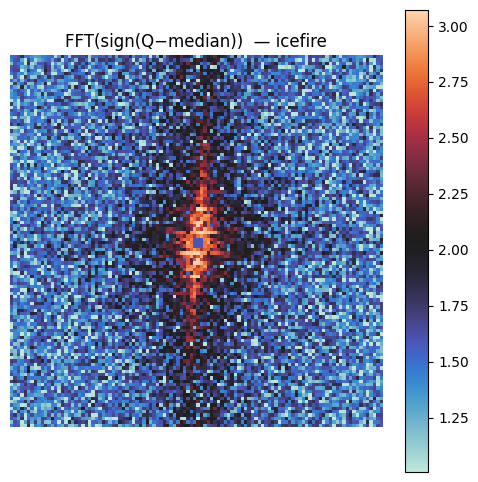

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Q_grid already loaded and NaNs filled -> Q_clean
Q0 = Q_clean - np.median(Q_clean)          # centre
Sgn = np.sign(Q0)                          # {-1,0,+1}
Sgn[Sgn == 0] = 1                          # avoid zeros

# (optional) emphasise structure: remove any residual mean
Sgn = Sgn - Sgn.mean()

Spec = np.fft.fftshift(np.fft.fft2(Sgn))
Spec = np.abs(Spec)
Spec_log = np.log10(Spec + 1e-12)

# mask DC
ny, nx = Spec_log.shape
cy, cx = ny//2, nx//2
Spec_log[cy-1:cy+2, cx-1:cx+2] = np.median(Spec_log)

# plot with a *wide* scale (not tight robust clipping)
cmap = sns.color_palette("icefire", as_cmap=True)
vmin = np.percentile(Spec_log, 5)
vmax = np.percentile(Spec_log, 99.9)

plt.figure(figsize=(6,6))
plt.imshow(Spec_log, cmap=cmap, vmin=vmin, vmax=vmax)
plt.axis("off")
plt.title("FFT(sign(Q−median))  — icefire")
plt.colorbar()
plt.show()

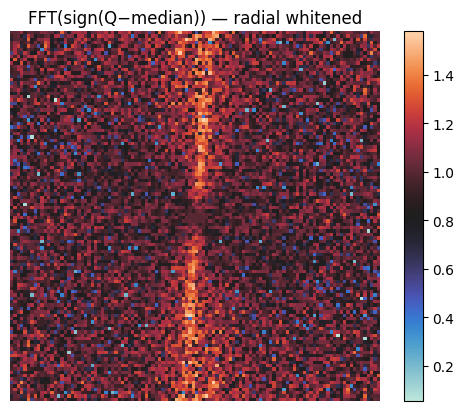

In [ ]:
# Spec_log already computed (log10|FFT|)
# Compute radial mean and divide

ny, nx = Spec_log.shape
cy, cx = ny//2, nx//2
Y, X = np.ogrid[:ny, :nx]
R = np.sqrt((Y-cy)**2 + (X-cx)**2).astype(int)

radial_mean = np.zeros(R.max()+1)
for r in range(len(radial_mean)):
    radial_mean[r] = np.median(Spec_log[R == r])

Spec_white = Spec_log / (radial_mean[R] + 1e-6)

plt.imshow(Spec_white, cmap="icefire")
plt.axis("off")
plt.title("FFT(sign(Q−median)) — radial whitened")
plt.colorbar()
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    ICEFIRE = sns.color_palette("icefire", as_cmap=True)
except Exception:
    import matplotlib.cm as cm
    ICEFIRE = cm.coolwarm

STRUCTURES = ["8F4G", "8F4H", "8F4I", "8F4J"]
SEARCH_ROOT = "/content/drive/MyDrive"
OUT_PNG = "/content/FFT_panel_GHIJ.png"

DC_RADIUS = 2
P_LOW = 2.0
P_HIGH = 99.8


def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                remembers = os.path.join(dirpath, fn)
                hits.append(remembers)
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]


def nanfill(A):
    A = np.array(A, float)
    mask = np.isfinite(A)
    A[~mask] = np.median(A[mask])
    return A


def fft_log_mag(field):
    F = np.fft.fftshift(np.fft.fft2(field))
    return np.log10(np.abs(F) + 1e-12)


def mask_dc(S, r=2):
    S = S.copy()
    ny, nx = S.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.ogrid[:ny, :nx]
    m = (Y - cy) ** 2 + (X - cx) ** 2 <= r ** 2
    S[m] = np.median(S)
    return S


def radial_whiten(S):
    S = S.copy()
    ny, nx = S.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.ogrid[:ny, :nx]
    R = np.sqrt((Y - cy) ** 2 + (X - cx) ** 2).astype(int)
    prof = np.zeros(R.max() + 1)
    for r in range(len(prof)):
        prof[r] = np.median(S[R == r])
    return S / (prof[R] + 1e-6)


def notch_vertical(S, halfwidth=2):
    S = S.copy()
    cx = S.shape[1] // 2
    S[:, cx - halfwidth:cx + halfwidth + 1] = np.median(S)
    return S


def make_views(Q, kappa):
    views = []

    A = np.abs(Q) - np.mean(np.abs(Q))
    views.append(("FFT(|Q|)", mask_dc(fft_log_mag(A), DC_RADIUS)))

    Q0 = Q - np.mean(Q)
    views.append(("FFT(Q)", mask_dc(fft_log_mag(Q0), DC_RADIUS)))

    Sgn = np.sign(Q - np.median(Q))
    Sgn[Sgn == 0] = 1
    Sgn = Sgn - np.mean(Sgn)
    views.append(("FFT(sign(Q−med))", mask_dc(fft_log_mag(Sgn), DC_RADIUS)))

    views.append(("FFT(sign) whiten", radial_whiten(views[-1][1])))

    if kappa is not None:
        K0 = np.abs(kappa) - np.mean(np.abs(kappa))
        views.append(("FFT(|κ|)", mask_dc(fft_log_mag(K0), DC_RADIUS)))
    else:
        views.append(("FFT(|κ|)", np.zeros_like(views[0][1])))

    S_notch = notch_vertical(views[1][1], halfwidth=2)
    views.append(("FFT(Q) notch+white", radial_whiten(S_notch)))

    return views


rows = []
titles = None

for s in STRUCTURES:
    path = find_npz(SEARCH_ROOT, s)
    data = np.load(path, allow_pickle=True)

    Q = nanfill(data["Q_grid"])
    kappa = nanfill(data["kappa_grid"]) if "kappa_grid" in data else None

    views = make_views(Q, kappa)
    if titles is None:
        titles = [t for t, _ in views]
    rows.append((s, views))


n_rows = len(rows)
n_cols = len(titles)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.6 * n_cols, 3.2 * n_rows))
if n_rows == 1:
    axes = np.array([axes])

scales = []
for j in range(n_cols):
    vals = []
    for _, v in rows:
        img = v[j][1]
        if np.isfinite(img).any():
            vals.append(img[np.isfinite(img)])
    allv = np.concatenate(vals)
    scales.append((np.percentile(allv, P_LOW), np.percentile(allv, P_HIGH)))

for i, (label, views) in enumerate(rows):
    for j, (title, img) in enumerate(views):
        ax = axes[i, j]
        vmin, vmax = scales[j]
        ax.imshow(img, cmap=ICEFIRE, origin="upper", vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(title)
        if j == 0:
            ax.set_ylabel(label)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()

print("Saved:", OUT_PNG)

Saved: /content/FFT_panel_GHIJ.png


In [ ]:
import os
import numpy as np
import pandas as pd

try:
    import scipy.ndimage as ndi
except Exception as e:
    raise RuntimeError("Please install scipy: !pip -q install scipy") from e


STRUCTURES = ["8F4G", "8F4H", "8F4I", "8F4J"]
SEARCH_ROOT = "/content/drive/MyDrive"
OUT_CSV = "/content/fft_quant_GHIJ.csv"

DC_RADIUS = 2
AXIAL_NOTCH_HALF_WIDTH = 2

RADIAL_BAND_HALF_WIDTH = 2
SMOOTH_SIGMA = 1.0


def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure} under {root}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]


def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    if not np.any(m):
        raise ValueError("Array has no finite values.")
    A[~m] = np.median(A[m])
    return A


def fft_mag(field):
    F = np.fft.fftshift(np.fft.fft2(field))
    return np.abs(F)


def mask_dc(M, r=2):
    M = M.copy()
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.ogrid[:ny, :nx]
    m = (Y - cy) ** 2 + (X - cx) ** 2 <= r ** 2
    M[m] = np.median(M)
    return M


def notch_axial(M, halfwidth=2):
    M = M.copy()
    cx = M.shape[1] // 2
    M[:, cx-halfwidth:cx+halfwidth+1] = np.median(M)
    return M


def radial_profile(M):
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.ogrid[:ny, :nx]
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)
    r = R.astype(int)
    prof = np.zeros(r.max() + 1)
    for rr in range(len(prof)):
        prof[rr] = np.median(M[r == rr])
    return prof


def dominant_radius(M):
    prof = radial_profile(M)
    r0 = 4
    r1 = min(len(prof)-1, max(10, int(0.45*len(prof))))
    segment = prof[r0:r1]
    rr = np.argmax(segment) + r0
    return rr, prof


def angle_grid(shape):
    ny, nx = shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx
    ang = np.arctan2(dy, dx)
    return ang


def sixfold_hexness(M, r_peak, band_hw=2):
    ang = angle_grid(M.shape)
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)
    band = (R >= (r_peak - band_hw)) & (R <= (r_peak + band_hw))

    vals = M[band]
    th = ang[band]

    nbins = 180
    bins = np.linspace(-np.pi, np.pi, nbins+1)
    bidx = np.digitize(th, bins) - 1
    curve = np.zeros(nbins)
    counts = np.zeros(nbins)

    for i, v in zip(bidx, vals):
        if 0 <= i < nbins:
            curve[i] += v
            counts[i] += 1

    curve = curve / (counts + 1e-12)
    curve = curve - np.mean(curve)

    F = np.fft.rfft(curve)
    amp = np.abs(F)
    k6 = 6
    if k6 >= len(amp):
        return np.nan

    h6 = amp[k6] / (np.sqrt(np.mean(amp[1:]**2)) + 1e-12)
    return float(h6)


def dominant_diagonal_angle(M, r_peak, band_hw=2):
    M2 = M.copy()
    ang = angle_grid(M2.shape)

    ny, nx = M2.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)
    band = (R >= (r_peak - band_hw)) & (R <= (r_peak + band_hw))

    vals = M2[band]
    th = ang[band]

    nbins = 180
    bins = np.linspace(-np.pi, np.pi, nbins+1)
    bidx = np.digitize(th, bins) - 1

    curve = np.zeros(nbins)
    counts = np.zeros(nbins)
    for i, v in zip(bidx, vals):
        if 0 <= i < nbins:
            curve[i] += v
            counts[i] += 1
    curve = curve / (counts + 1e-12)

    imax = int(np.argmax(curve))
    theta = 0.5*(bins[imax] + bins[imax+1])
    theta_deg = (np.degrees(theta) + 360) % 180
    return float(theta_deg), curve


def axial_anisotropy(M):
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx
    ang = np.arctan2(dy, dx)

    band = (np.sqrt(dy**2 + dx**2) > 5)

    vertical = band & (np.abs(dx) <= 2)
    horizontal = band & (np.abs(dy) <= 2)

    v = np.median(M[vertical])
    h = np.median(M[horizontal])
    return float((v - h) / (np.abs(h) + 1e-12))


def compute_metrics(field2d):
    F = np.abs(field2d)
    F = F - np.mean(F)

    M = fft_mag(F)
    M = ndi.gaussian_filter(M, SMOOTH_SIGMA)
    M = mask_dc(M, DC_RADIUS)

    ax = axial_anisotropy(M)

    M_noax = notch_axial(M, AXIAL_NOTCH_HALF_WIDTH)
    r_peak, prof = dominant_radius(M_noax)

    theta_deg, _ = dominant_diagonal_angle(M_noax, r_peak, RADIAL_BAND_HALF_WIDTH)
    h6 = sixfold_hexness(M_noax, r_peak, RADIAL_BAND_HALF_WIDTH)

    return {
        "r_peak_px": r_peak,
        "theta_deg": theta_deg,
        "hexness_H6": h6,
        "axial_A": ax
    }


rows = []

for s in STRUCTURES:
    npz = find_npz(SEARCH_ROOT, s)
    data = np.load(npz, allow_pickle=True)

    Q = nanfill(data["Q_grid"])
    kappa = nanfill(data["kappa_grid"]) if "kappa_grid" in data else None

    mQ = compute_metrics(Q)
    mQ["structure"] = s
    mQ["channel"] = "Q"
    rows.append(mQ)

    if kappa is not None:
        mk = compute_metrics(kappa)
        mk["structure"] = s
        mk["channel"] = "kappa"
        rows.append(mk)

df = pd.DataFrame(rows)
df = df[["structure", "channel", "r_peak_px", "theta_deg", "hex

SyntaxError: unterminated string literal (detected at line 226) (ipython-input-438009242.py, line 226)

In [ ]:
import os
import numpy as np
import pandas as pd

try:
    import scipy.ndimage as ndi
except Exception as e:
    raise RuntimeError("Please install scipy: !pip -q install scipy") from e


STRUCTURES = ["8F4G", "8F4H", "8F4I", "8F4J"]
SEARCH_ROOT = "/content/drive/MyDrive"
OUT_CSV = "/content/fft_quant_GHIJ.csv"

DC_RADIUS = 2
AXIAL_NOTCH_HALF_WIDTH = 2

RADIAL_BAND_HALF_WIDTH = 2
SMOOTH_SIGMA = 1.0


def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure} under {root}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]


def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    if not np.any(m):
        raise ValueError("Array has no finite values.")
    A[~m] = np.median(A[m])
    return A


def fft_mag(field):
    F = np.fft.fftshift(np.fft.fft2(field))
    return np.abs(F)


def mask_dc(M, r=2):
    M = M.copy()
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.ogrid[:ny, :nx]
    m = (Y - cy) ** 2 + (X - cx) ** 2 <= r ** 2
    M[m] = np.median(M)
    return M


def notch_axial(M, halfwidth=2):
    M = M.copy()
    cx = M.shape[1] // 2
    M[:, cx-halfwidth:cx+halfwidth+1] = np.median(M)
    return M


def radial_profile(M):
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.ogrid[:ny, :nx]
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)
    r = R.astype(int)
    prof = np.zeros(r.max() + 1)
    for rr in range(len(prof)):
        prof[rr] = np.median(M[r == rr])
    return prof


def dominant_radius(M):
    prof = radial_profile(M)
    r0 = 4
    r1 = min(len(prof)-1, max(10, int(0.45*len(prof))))
    segment = prof[r0:r1]
    rr = np.argmax(segment) + r0
    return rr, prof


def angle_grid(shape):
    ny, nx = shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx
    ang = np.arctan2(dy, dx)
    return ang


def sixfold_hexness(M, r_peak, band_hw=2):
    ang = angle_grid(M.shape)
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)
    band = (R >= (r_peak - band_hw)) & (R <= (r_peak + band_hw))

    vals = M[band]
    th = ang[band]

    nbins = 180
    bins = np.linspace(-np.pi, np.pi, nbins+1)
    bidx = np.digitize(th, bins) - 1
    curve = np.zeros(nbins)
    counts = np.zeros(nbins)

    for i, v in zip(bidx, vals):
        if 0 <= i < nbins:
            curve[i] += v
            counts[i] += 1

    curve = curve / (counts + 1e-12)
    curve = curve - np.mean(curve)

    F = np.fft.rfft(curve)
    amp = np.abs(F)
    k6 = 6
    if k6 >= len(amp):
        return np.nan

    h6 = amp[k6] / (np.sqrt(np.mean(amp[1:]**2)) + 1e-12)
    return float(h6)


def dominant_diagonal_angle(M, r_peak, band_hw=2):
    M2 = M.copy()
    ang = angle_grid(M2.shape)

    ny, nx = M2.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)
    band = (R >= (r_peak - band_hw)) & (R <= (r_peak + band_hw))

    vals = M2[band]
    th = ang[band]

    nbins = 180
    bins = np.linspace(-np.pi, np.pi, nbins+1)
    bidx = np.digitize(th, bins) - 1

    curve = np.zeros(nbins)
    counts = np.zeros(nbins)
    for i, v in zip(bidx, vals):
        if 0 <= i < nbins:
            curve[i] += v
            counts[i] += 1
    curve = curve / (counts + 1e-12)

    imax = int(np.argmax(curve))
    theta = 0.5*(bins[imax] + bins[imax+1])
    theta_deg = (np.degrees(theta) + 360) % 180
    return float(theta_deg), curve


def axial_anisotropy(M):
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx
    ang = np.arctan2(dy, dx)

    band = (np.sqrt(dy**2 + dx**2) > 5)

    vertical = band & (np.abs(dx) <= 2)
    horizontal = band & (np.abs(dy) <= 2)

    v = np.median(M[vertical])
    h = np.median(M[horizontal])
    return float((v - h) / (np.abs(h) + 1e-12))


def compute_metrics(field2d):
    F = np.abs(field2d)
    F = F - np.mean(F)

    M = fft_mag(F)
    M = ndi.gaussian_filter(M, SMOOTH_SIGMA)
    M = mask_dc(M, DC_RADIUS)

    ax = axial_anisotropy(M)

    M_noax = notch_axial(M, AXIAL_NOTCH_HALF_WIDTH)
    r_peak, prof = dominant_radius(M_noax)

    theta_deg, _ = dominant_diagonal_angle(M_noax, r_peak, RADIAL_BAND_HALF_WIDTH)
    h6 = sixfold_hexness(M_noax, r_peak, RADIAL_BAND_HALF_WIDTH)

    return {
        "r_peak_px": r_peak,
        "theta_deg": theta_deg,
        "hexness_H6": h6,
        "axial_A": ax
    }


rows = []

for s in STRUCTURES:
    npz = find_npz(SEARCH_ROOT, s)
    data = np.load(npz, allow_pickle=True)

    Q = nanfill(data["Q_grid"])
    kappa = nanfill(data["kappa_grid"]) if "kappa_grid" in data else None

    mQ = compute_metrics(Q)
    mQ["structure"] = s
    mQ["channel"] = "Q"
    rows.append(mQ)

    if kappa is not None:
        mk = compute_metrics(kappa)
        mk["structure"] = s
        mk["channel"] = "kappa"
        rows.append(mk)

df = pd.DataFrame(rows)
df = df[["structure", "channel", "r_peak_px", "theta_deg", "hexness_H6", "axial_A"]]
df.to_csv(OUT_CSV, index=False)

print(df.to_string(index=False))
print("Saved:", OUT_CSV)

structure channel  r_peak_px  theta_deg  hexness_H6   axial_A
     8F4G       Q          4      161.0    0.488300  0.145223
     8F4G   kappa          4       19.0    0.479582  0.130753
     8F4H       Q          4       37.0    1.003076 -0.018674
     8F4H   kappa          5       37.0    0.705187 -0.021056
     8F4I       Q          4      127.0    0.612157  0.181876
     8F4I   kappa          5      127.0    0.539768  0.175147
     8F4J       Q          4      127.0    1.155918  1.407444
     8F4J   kappa          4      127.0    1.104167  1.339329
Saved: /content/fft_quant_GHIJ.csv


In [ ]:
import os
import numpy as np
import pandas as pd

try:
    import scipy.ndimage as ndi
except Exception as e:
    raise RuntimeError("Install scipy: !pip -q install scipy") from e


STRUCTURES = ["8F4G", "8F4H", "8F4I", "8F4J"]
SEARCH_ROOT = "/content/drive/MyDrive"
OUT_CSV = "/content/fft_shellscan_GHIJ.csv"

DC_RADIUS = 2
SMOOTH_SIGMA = 1.0
BAND_HW = 2


def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]


def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    A[~m] = np.median(A[m])
    return A


def fft_mag(field):
    F = np.fft.fftshift(np.fft.fft2(field))
    return np.abs(F)


def mask_dc(M, r=2):
    M = M.copy()
    ny, nx = M.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.ogrid[:ny, :nx]
    m = (Y - cy) ** 2 + (X - cx) ** 2 <= r ** 2
    M[m] = np.median(M)
    return M


def angle_and_radius(shape):
    ny, nx = shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx
    ang = np.arctan2(dy, dx)
    rad = np.sqrt(dy**2 + dx**2)
    return ang, rad


def hexness_shell(M, r0, band_hw=2, nbins=180):
    ang, rad = angle_and_radius(M.shape)
    band = (rad >= (r0 - band_hw)) & (rad <= (r0 + band_hw))
    vals = M[band]
    th = ang[band]

    bins = np.linspace(-np.pi, np.pi, nbins + 1)
    idx = np.digitize(th, bins) - 1

    curve = np.zeros(nbins)
    counts = np.zeros(nbins)
    for i, v in zip(idx, vals):
        if 0 <= i < nbins:
            curve[i] += v
            counts[i] += 1

    curve = curve / (counts + 1e-12)
    curve = curve - np.mean(curve)

    F = np.fft.rfft(curve)
    amp = np.abs(F)
    k6 = 6
    return float(amp[k6] / (np.sqrt(np.mean(amp[1:]**2)) + 1e-12))


def shell_scan(field2d, label):
    F = np.abs(field2d)
    F = F - np.mean(F)

    M = fft_mag(F)
    M = ndi.gaussian_filter(M, SMOOTH_SIGMA)
    M = mask_dc(M, DC_RADIUS)

    ang, rad = angle_and_radius(M.shape)
    rmax = int(rad.max()) - 2

    rs = np.arange(3, rmax)
    h6s = np.array([hexness_shell(M, r, BAND_HW) for r in rs])

    imax = int(np.argmax(h6s))
    h6_max = float(h6s[imax])
    r_at_max = int(rs[imax])

    half = 0.5 * h6_max
    above = rs[h6s >= half]
    width = int(above.max() - above.min()) if len(above) else 0

    spread = float(np.std(h6s))

    return h6_max, r_at_max, width, spread


rows = []

for s in STRUCTURES:
    npz = find_npz(SEARCH_ROOT, s)
    data = np.load(npz, allow_pickle=True)

    Q = nanfill(data["Q_grid"])
    kappa = nanfill(data["kappa_grid"]) if "kappa_grid" in data else None

    h6max, rmax, width, spread = shell_scan(Q, "Q")
    rows.append(dict(structure=s, channel="Q",
                     H6_max=h6max, r_at_H6_max=rmax,
                     H6_halfmax_width=width, H6_std=spread))

    if kappa is not None:
        h6max, rmax, width, spread = shell_scan(kappa, "kappa")
        rows.append(dict(structure=s, channel="kappa",
                         H6_max=h6max, r_at_H6_max=rmax,
                         H6_halfmax_width=width, H6_std=spread))

df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
print(df.to_string(index=False))
print("Saved:", OUT_CSV)


structure channel   H6_max  r_at_H6_max  H6_halfmax_width   H6_std
     8F4G       Q 2.999059           28                47 0.751496
     8F4G   kappa 2.927551           28                47 0.779167
     8F4H       Q 6.215195           41                34 1.836682
     8F4H   kappa 6.369129           41                34 1.863600
     8F4I       Q 3.980993           35                45 1.113496
     8F4I   kappa 4.000588           35                45 1.118805
     8F4J       Q 4.211957           25                45 1.229147
     8F4J   kappa 4.212742           25                45 1.220342
Saved: /content/fft_shellscan_GHIJ.csv


In [ ]:
import pandas as pd

csv_path = "/content/fft_shellscan_GHIJ.csv"
df = pd.read_csv(csv_path)

df["sheetness"] = (df["H6_std"] * df["H6_halfmax_width"]) / (df["H6_max"] + 1e-12)

df2 = df.sort_values(["channel", "sheetness"], ascending=[True, False])

print(df2[["structure", "channel", "H6_max", "r_at_H6_max", "H6_halfmax_width", "H6_std", "sheetness"]].to_string(index=False))

structure channel   H6_max  r_at_H6_max  H6_halfmax_width   H6_std  sheetness
     8F4J       Q 4.211957           25                45 1.229147  13.132049
     8F4I       Q 3.980993           35                45 1.113496  12.586641
     8F4G       Q 2.999059           28                47 0.751496  11.777127
     8F4H       Q 6.215195           41                34 1.836682  10.047504
     8F4J   kappa 4.212742           25                45 1.220342  13.035546
     8F4I   kappa 4.000588           35                45 1.118805  12.584707
     8F4G   kappa 2.927551           28                47 0.779167  12.509043
     8F4H   kappa 6.369129           41                34 1.863600   9.948361


In [ ]:
import pandas as pd

df1 = pd.read_csv("/content/fft_shellscan_GHIJ.csv")
df2 = pd.read_csv("/content/fft_quant_GHIJ.csv")

df = df1.merge(df2[["structure","channel","axial_A"]],
               on=["structure","channel"],
               how="left")

df["sheetness2"] = (
    df["H6_std"] * df["H6_halfmax_width"]
    / (df["H6_max"] * (1.0 + df["axial_A"].abs()) + 1e-12)
)

print(
    df.sort_values(["channel","sheetness2"], ascending=[True, False])
      [["structure","channel","sheetness2","H6_max","H6_halfmax_width","H6_std","axial_A"]]
      .to_string(index=False)
)

structure channel  sheetness2   H6_max  H6_halfmax_width   H6_std   axial_A
     8F4I       Q   10.649709 3.980993                45 1.113496  0.181876
     8F4G       Q   10.283696 2.999059                47 0.751496  0.145223
     8F4H       Q    9.863316 6.215195                34 1.836682 -0.018674
     8F4J       Q    5.454768 4.211957                45 1.229147  1.407444
     8F4G   kappa   11.062580 2.927551                47 0.779167  0.130753
     8F4I   kappa   10.709048 4.000588                45 1.118805  0.175147
     8F4H   kappa    9.743206 6.369129                34 1.863600 -0.021056
     8F4J   kappa    5.572344 4.212742                45 1.220342  1.339329


In [ ]:
import pandas as pd

df = pd.read_csv("/content/fft_shellscan_GHIJ.csv")

df["spikey"] = df["H6_max"] / (df["H6_halfmax_width"] + 1e-12)

print(
    df.sort_values(["channel","spikey"], ascending=[True, False])
      [["structure","channel","spikey","H6_max","H6_halfmax_width"]]
      .to_string(index=False)
)

structure channel   spikey   H6_max  H6_halfmax_width
     8F4H       Q 0.182800 6.215195                34
     8F4J       Q 0.093599 4.211957                45
     8F4I       Q 0.088467 3.980993                45
     8F4G       Q 0.063810 2.999059                47
     8F4H   kappa 0.187327 6.369129                34
     8F4J   kappa 0.093616 4.212742                45
     8F4I   kappa 0.088902 4.000588                45
     8F4G   kappa 0.062288 2.927551                47


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    ICEFIRE = sns.color_palette("icefire", as_cmap=True)
except Exception:
    import matplotlib.cm as cm
    ICEFIRE = cm.coolwarm

STRUCTURE = "8F4I"
SEARCH_ROOT = "/content/drive/MyDrive"
OUT_PNG = "/content/HEX_RECOVERY_8F4I.png"

DC_RADIUS = 2
NOTCH_HALF = 3

def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]

def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    A[~m] = np.median(A[m])
    return A

def fft2(field):
    return np.fft.fftshift(np.fft.fft2(field))

def mask_dc(F, r=2):
    F = F.copy()
    ny, nx = F.shape
    cy, cx = ny//2, nx//2
    Y, X = np.ogrid[:ny, :nx]
    m = (Y-cy)**2 + (X-cx)**2 <= r**2
    F[m] = np.median(F)
    return F

def notch_vertical_band(F, half=3):
    F = F.copy()
    cx = F.shape[1]//2
    F[:, cx-half:cx+half+1] = np.median(F)
    return F

def radial_whiten_mag(M):
    ny, nx = M.shape
    cy, cx = ny//2, nx//2
    Y, X = np.indices((ny, nx))
    R = np.sqrt((Y-cy)**2 + (X-cx)**2).astype(int)
    prof = np.zeros(R.max()+1)
    for r in range(len(prof)):
        prof[r] = np.median(M[R==r])
    return M / (prof[R] + 1e-12)

npz = find_npz(SEARCH_ROOT, STRUCTURE)
d = np.load(npz, allow_pickle=True)

Q = nanfill(d["Q_grid"])
K = nanfill(d["kappa_grid"]) if "kappa_grid" in d else None
if K is None:
    raise RuntimeError("No kappa_grid found in NPZ.")

field = np.abs(K) - np.mean(np.abs(K))

F = fft2(field)
F = mask_dc(F, DC_RADIUS)

mag = np.abs(F)
mag = radial_whiten_mag(mag)

mag = notch_vertical_band(mag, NOTCH_HALF)

img = np.log10(mag + 1e-12)

vmin = np.percentile(img, 5)
vmax = np.percentile(img, 99.7)

plt.figure(figsize=(7, 6))
plt.imshow(img, cmap=ICEFIRE, vmin=vmin, vmax=vmax, origin="upper")
plt.axis("off")
plt.title("8F4I: κ FFT (radial-whitened, axial-notched) — hex recovery")
plt.colorbar(label="log10 whitened |FFT|")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()

print("Saved:", OUT_PNG)

Saved: /content/HEX_RECOVERY_8F4I.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    ICEFIRE = sns.color_palette("icefire", as_cmap=True)
except Exception:
    import matplotlib.cm as cm
    ICEFIRE = cm.coolwarm

STRUCTURE = "8F4I"
SEARCH_ROOT = "/content/drive/MyDrive"
OUT_PNG = "/content/8F4I_hex_recon_shell.png"

R0 = 35          # your r_at_H6_max for 8F4I
DR = 2           # shell half-width (try 1..4)

def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]

def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    A[~m] = np.median(A[m])
    return A

npz = find_npz(SEARCH_ROOT, STRUCTURE)
d = np.load(npz, allow_pickle=True)

# Use kappa because it gave the clearest diagonal order in your panel
K = nanfill(d["kappa_grid"])
field = np.abs(K) - np.mean(np.abs(K))

F = np.fft.fftshift(np.fft.fft2(field))

ny, nx = field.shape
cy, cx = ny // 2, nx // 2
Y, X = np.indices((ny, nx))
R = np.sqrt((Y - cy)**2 + (X - cx)**2)

mask = (R >= (R0 - DR)) & (R <= (R0 + DR))

F_filt = np.zeros_like(F)
F_filt[mask] = F[mask]

recon = np.fft.ifft2(np.fft.ifftshift(F_filt))
recon = np.real(recon)

vmin = np.percentile(recon, 2)
vmax = np.percentile(recon, 98)

plt.figure(figsize=(6, 6))
plt.imshow(recon, cmap=ICEFIRE, vmin=vmin, vmax=vmax, origin="upper")
plt.axis("off")
plt.title(f"{STRUCTURE}: inverse-FFT of shell r≈{R0}±{DR} (from |κ|)")
plt.colorbar(label="reconstructed intensity")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()
print("Saved:", OUT_PNG)

Saved: /content/8F4I_hex_recon_shell.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    ICEFIRE = sns.color_palette("icefire", as_cmap=True)
except Exception:
    import matplotlib.cm as cm
    ICEFIRE = cm.coolwarm

SEARCH_ROOT = "/content/drive/MyDrive"
OUT_PNG = "/content/hex_sheet_recon_GHIJ.png"

RADII = {
    "8F4G": 35,
    "8F4H": 35,
    "8F4I": 35,
    "8F4J": 35,
}
DR = 2

def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]

def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    if not np.any(m):
        raise ValueError("Array has no finite values.")
    A[~m] = np.median(A[m])
    return A

def shell_ifft_from_field(field, r0, dr):
    field = np.abs(field)
    field = field - np.mean(field)

    F = np.fft.fftshift(np.fft.fft2(field))

    ny, nx = field.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)

    shell = (R >= (r0 - dr)) & (R <= (r0 + dr))

    F_filt = np.zeros_like(F)
    F_filt[shell] = F[shell]

    recon = np.fft.ifft2(np.fft.ifftshift(F_filt))
    recon = np.real(recon)
    return recon

recons = {}
for s, r0 in RADII.items():
    npz = find_npz(SEARCH_ROOT, s)
    d = np.load(npz, allow_pickle=True)

    if "kappa_grid" not in d:
        raise KeyError(f"{s}: NPZ has no kappa_grid")

    K = nanfill(d["kappa_grid"])
    recons[s] = shell_ifft_from_field(K, r0, DR)

all_vals = np.concatenate([recons[s].ravel() for s in RADII])
vmin = np.percentile(all_vals, 2)
vmax = np.percentile(all_vals, 98)

fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.ravel()

for ax, s in zip(axes, ["8F4G", "8F4H", "8F4I", "8F4J"]):
    r0 = RADII[s]
    ax.imshow(recons[s], cmap=ICEFIRE, vmin=vmin, vmax=vmax, origin="upper")
    ax.set_title(f"{s}: iFFT shell r≈{r0}±{DR} from |κ|")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()
print("Saved:", OUT_PNG)

Saved: /content/hex_sheet_recon_GHIJ.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    ICEFIRE = sns.color_palette("icefire", as_cmap=True)
except Exception:
    import matplotlib.cm as cm
    ICEFIRE = cm.coolwarm

SEARCH_ROOT = "/content/drive/MyDrive"
OUT_PNG = "/content/hex_wedge_recon_GHIJ.png"

STRUCTURES = ["8F4G", "8F4H", "8F4I", "8F4J"]

R0 = 35
DR = 2

WEDGE_HALF_DEG = 8.0  # try 5..12 (smaller = cleaner hex, larger = more energy)

def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]

def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    if not np.any(m):
        raise ValueError("Array has no finite values.")
    A[~m] = np.median(A[m])
    return A

def wrap_angle_deg(a):
    return (a + 180.0) % 360.0 - 180.0

def hex_wedge_mask(shape, r0, dr, wedge_half_deg):
    ny, nx = shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx

    R = np.sqrt(dy**2 + dx**2)
    theta = np.degrees(np.arctan2(dy, dx))  # [-180,180]

    shell = (R >= (r0 - dr)) & (R <= (r0 + dr))

    centers = np.array([0, 60, 120, 180, 240, 300], dtype=float)
    ok = np.zeros_like(theta, dtype=bool)
    for c in centers:
        dth = wrap_angle_deg(theta - c)
        ok |= (np.abs(dth) <= wedge_half_deg)

    return shell & ok

def shell_hex_ifft(field2d, r0, dr, wedge_half_deg):
    field = np.abs(field2d)
    field = field - np.mean(field)

    F = np.fft.fftshift(np.fft.fft2(field))

    mask = hex_wedge_mask(field.shape, r0, dr, wedge_half_deg)

    Ff = np.zeros_like(F)
    Ff[mask] = F[mask]

    recon = np.fft.ifft2(np.fft.ifftshift(Ff))
    recon = np.real(recon)
    return recon

recons = {}
for s in STRUCTURES:
    npz = find_npz(SEARCH_ROOT, s)
    d = np.load(npz, allow_pickle=True)
    if "kappa_grid" not in d:
        raise KeyError(f"{s}: NPZ missing kappa_grid")
    K = nanfill(d["kappa_grid"])
    recons[s] = shell_hex_ifft(K, R0, DR, WEDGE_HALF_DEG)

allv = np.concatenate([recons[s].ravel() for s in STRUCTURES])
vmin = np.percentile(allv, 2)
vmax = np.percentile(allv, 98)

fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.ravel()

for ax, s in zip(axes, STRUCTURES):
    ax.imshow(recons[s], cmap=ICEFIRE, vmin=vmin, vmax=vmax, origin="upper")
    ax.set_title(f"{s}: iFFT shell r≈{R0}±{DR} with 6 wedges (|κ|)")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.close()
print("Saved:", OUT_PNG)

Saved: /content/hex_wedge_recon_GHIJ.png


In [ ]:
import os
import numpy as np

def reconstruct_hex_sheet_v1(
    npz_path,
    out_png="/content/hex_sheet_v1.png",
    out_npz="/content/hex_sheet_v1_receipt.npz",
    channel="kappa",
    dr=2,
    dc_radius=2,
    axial_notch_halfwidth=2,
    recentre=True,
    nbins=180,
    r_min=3,
    r_max_frac=0.48,
    display_percentiles=(2, 98),
    use_icefire=True,
):
    """
    Hex-sheet reconstruction v1.0 (canonical)

    What it does:
      1) Load a 2D field on the (duty, beta) grid from NPZ: kappa_grid (default) or Q_grid.
      2) Compute FFT(field) in complex k-space.
      3) Auto-pick the dominant "hex shell" radius r0 by scanning radii and maximizing the 6-fold
         angular modulation (H6) on |FFT|.
      4) Build a thin radial shell mask r0±dr in k-space and (optionally) notch axial bands to
         reduce spine leakage.
      5) Apply the mask to the COMPLEX FFT and inverse FFT -> reconstructed real-space packet sheet.
      6) Recentre the reconstruction by the largest-magnitude packet (stabilises centrality).
      7) Save PNG + a receipt NPZ containing r0, H6 curve, mask params, and the reconstruction.

    Why this is the “right” reproducible method:
      - It does NOT force hex symmetry.
      - It does NOT depend on colormaps or manual radius picking.
      - The shell radius is selected from the data via an explicit H6 criterion.
      - The exact parameters used are saved, so you can recreate the figure later exactly.

    Returns:
      recon (2D float array), meta (dict)
    """

    # ---------- Imports kept inside so the function is portable ----------
    import matplotlib.pyplot as plt

    if use_icefire:
        try:
            import seaborn as sns
            cmap = sns.color_palette("icefire", as_cmap=True)
        except Exception:
            cmap = "magma"
    else:
        cmap = "magma"

    # ---------- Load ----------
    d = np.load(npz_path, allow_pickle=True)

    key = "kappa_grid" if channel.lower() == "kappa" else "Q_grid"
    if key not in d:
        raise KeyError(f"NPZ missing '{key}'. Available keys: {', '.join(list(d.keys()))}")

    field = np.array(d[key], dtype=float)

    # ---------- NaN fill ----------
    m = np.isfinite(field)
    if not np.any(m):
        raise ValueError(f"{key} contains no finite values.")
    field[~m] = np.median(field[m])

    # ---------- Preprocess field ----------
    # Use magnitude (amplitude-level ordering), then demean.
    f0 = np.abs(field)
    f0 = f0 - np.mean(f0)

    # ---------- FFT (complex) ----------
    F = np.fft.fftshift(np.fft.fft2(f0))

    ny, nx = f0.shape
    cy, cx = ny // 2, nx // 2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx
    R = np.sqrt(dy**2 + dx**2)
    TH = np.arctan2(dy, dx)  # [-pi, pi]

    # ---------- Remove DC spike influence in the magnitude used for scoring ----------
    M = np.abs(F).copy()

    if dc_radius and dc_radius > 0:
        dc_mask = (dy**2 + dx**2) <= (dc_radius**2)
        M[dc_mask] = np.median(M[~dc_mask])

    # ---------- Helper: H6 score on a radial shell ----------
    def h6_at_radius(Mmag, r0, band_hw=2, nbins=180):
        band = (R >= (r0 - band_hw)) & (R <= (r0 + band_hw))
        vals = Mmag[band]
        ang  = TH[band]

        bins = np.linspace(-np.pi, np.pi, nbins + 1)
        idx = np.digitize(ang, bins) - 1

        curve = np.zeros(nbins, dtype=float)
        counts = np.zeros(nbins, dtype=float)

        for i, v in zip(idx, vals):
            if 0 <= i < nbins:
                curve[i] += v
                counts[i] += 1.0

        curve = curve / (counts + 1e-12)
        curve = curve - np.mean(curve)

        spec = np.fft.rfft(curve)
        amp = np.abs(spec)

        k6 = 6
        if k6 >= len(amp):
            return np.nan, curve

        denom = np.sqrt(np.mean(amp[1:]**2)) + 1e-12
        return float(amp[k6] / denom), curve

    # ---------- Scan radii to choose r0 ----------
    rmax = int(np.max(R) * r_max_frac)
    rmax = max(rmax, r_min + 5)

    radii = np.arange(r_min, rmax + 1)
    h6_scores = np.zeros_like(radii, dtype=float)

    best_curve = None
    best_r0 = None
    best_h6 = -np.inf

    for k, r0 in enumerate(radii):
        h6, curve = h6_at_radius(M, r0, band_hw=max(1, dr), nbins=nbins)
        h6_scores[k] = h6
        if np.isfinite(h6) and h6 > best_h6:
            best_h6 = h6
            best_r0 = int(r0)
            best_curve = curve

    if best_r0 is None:
        raise RuntimeError("Failed to find a valid shell radius r0 (H6 scan returned no finite values).")

    # ---------- Build k-space mask: thin shell around best_r0 ----------
    shell = (R >= (best_r0 - dr)) & (R <= (best_r0 + dr))

    # Optional: reduce axial leakage (spine) by notching kx≈0 and ky≈0 bands inside the shell.
    # This helps prevent cross-hair dominance when axial modes leak into the selected shell.
    if axial_notch_halfwidth and axial_notch_halfwidth > 0:
        kx0 = np.abs(dx) <= axial_notch_halfwidth
        ky0 = np.abs(dy) <= axial_notch_halfwidth
        axial = (kx0 | ky0)
        shell = shell & (~axial)

    # ---------- Apply mask to COMPLEX FFT and inverse FFT ----------
    Ff = np.zeros_like(F)
    Ff[shell] = F[shell]

    recon_c = np.fft.ifft2(np.fft.ifftshift(Ff))
    recon = np.real(recon_c)

    # ---------- Recentre by dominant packet (stabilises presentation across structures) ----------
    if recentre:
        iy, ix = np.unravel_index(np.argmax(np.abs(recon)), recon.shape)
        shift_y = (ny // 2) - iy
        shift_x = (nx // 2) - ix
        recon = np.roll(np.roll(recon, shift_y, axis=0), shift_x, axis=1)

    # ---------- Save PNG ----------
    p_lo, p_hi = display_percentiles
    vmin = np.percentile(recon, p_lo)
    vmax = np.percentile(recon, p_hi)

    plt.figure(figsize=(6.5, 6.0))
    plt.imshow(recon, cmap=cmap, origin="upper", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"hex-sheet v1 | {os.path.basename(npz_path)} | {key} | r≈{best_r0}±{dr}")
    plt.colorbar(label="reconstructed intensity (clipped)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    # ---------- Save receipt NPZ ----------
    meta = {
        "npz_path": npz_path,
        "channel": key,
        "best_r0": best_r0,
        "dr": dr,
        "best_h6": float(best_h6),
        "dc_radius": dc_radius,
        "axial_notch_halfwidth": axial_notch_halfwidth,
        "recentre": bool(recentre),
        "nbins": nbins,
        "r_min": r_min,
        "r_max_used": int(rmax),
        "display_percentiles": tuple(display_percentiles),
    }

    np.savez(
        out_npz,
        recon=recon,
        h6_scores=h6_scores,
        radii=radii,
        best_curve=best_curve if best_curve is not None else np.array([]),
        meta=np.array([meta], dtype=object),
    )

    return recon, meta

In [ ]:
recon, meta = reconstruct_hex_sheet_v1(
    npz_path="/content/drive/MyDrive/dj_maps_8F4I_LIGHT/DJ_8F4I_g_gamma_Q_kappa_LIGHT.npz",
    out_png="/content/8F4I_hex_sheet_v1.png",
    out_npz="/content/8F4I_hex_sheet_v1_receipt.npz",
    channel="kappa",
    dr=2,
)
print(meta)

{'npz_path': '/content/drive/MyDrive/dj_maps_8F4I_LIGHT/DJ_8F4I_g_gamma_Q_kappa_LIGHT.npz', 'channel': 'kappa_grid', 'best_r0': 15, 'dr': 2, 'best_h6': 2.572355107201914, 'dc_radius': 2, 'axial_notch_halfwidth': 2, 'recentre': True, 'nbins': 180, 'r_min': 3, 'r_max_used': 20, 'display_percentiles': (2, 98)}


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    ICEFIRE = sns.color_palette("icefire", as_cmap=True)
except Exception:
    import matplotlib.cm as cm
    ICEFIRE = cm.coolwarm

SEARCH_ROOT = "/content/drive/MyDrive"
STRUCTURE = "8F4I"
OUT_PNG = "/content/hex_candidates_8F4I.png"

def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]

def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    A[~m] = np.median(A[m])
    return A

def fft2(field):
    return np.fft.fftshift(np.fft.fft2(field))

def ifft2(F):
    return np.fft.ifft2(np.fft.ifftshift(F))

def recenter_by_peak(A):
    B = np.array(A, copy=True)
    ny, nx = B.shape
    iy, ix = np.unravel_index(np.argmax(np.abs(B)), B.shape)
    dy = ny//2 - iy
    dx = nx//2 - ix
    return np.roll(np.roll(B, dy, axis=0), dx, axis=1)

def auto_pick_r0_from_field(field_abs, r_min=3, r_max_frac=0.48, band_hw=2, nbins=180):
    field_abs = field_abs - field_abs.mean()
    F = fft2(field_abs)
    M = np.abs(F)

    ny, nx = M.shape
    cy, cx = ny//2, nx//2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx
    R = np.sqrt(dy**2 + dx**2)
    TH = np.arctan2(dy, dx)

    rmax = int(R.max() * r_max_frac)
    radii = np.arange(r_min, max(r_min+10, rmax))

    def h6_at_r(r0):
        band = (R >= (r0-band_hw)) & (R <= (r0+band_hw))
        vals = M[band]
        ang = TH[band]
        bins = np.linspace(-np.pi, np.pi, nbins+1)
        idx = np.digitize(ang, bins) - 1
        curve = np.zeros(nbins)
        counts = np.zeros(nbins)
        for i, v in zip(idx, vals):
            if 0 <= i < nbins:
                curve[i] += v
                counts[i] += 1
        curve = curve / (counts + 1e-12)
        curve = curve - curve.mean()
        spec = np.fft.rfft(curve)
        amp = np.abs(spec)
        k6 = 6
        denom = np.sqrt(np.mean(amp[1:]**2)) + 1e-12
        return amp[k6] / denom

    scores = np.array([h6_at_r(r) for r in radii])
    return int(radii[np.argmax(scores)])

def shell_recon(field, r0, dr, axial_notch_halfwidth=0, recentre=False):
    field_abs = np.abs(field)
    field_abs = field_abs - field_abs.mean()

    F = fft2(field_abs)

    ny, nx = field_abs.shape
    cy, cx = ny//2, nx//2
    Y, X = np.indices((ny, nx))
    dy = Y - cy
    dx = X - cx
    R = np.sqrt(dy**2 + dx**2)

    mask = (R >= (r0-dr)) & (R <= (r0+dr))

    if axial_notch_halfwidth and axial_notch_halfwidth > 0:
        kx0 = np.abs(dx) <= axial_notch_halfwidth
        ky0 = np.abs(dy) <= axial_notch_halfwidth
        mask = mask & (~(kx0 | ky0))

    Ff = np.zeros_like(F)
    Ff[mask] = F[mask]

    recon = np.real(ifft2(Ff))

    if recentre:
        recon = recenter_by_peak(recon)

    return recon

npz = find_npz(SEARCH_ROOT, STRUCTURE)
d = np.load(npz, allow_pickle=True)
Q = nanfill(d["Q_grid"])
K = nanfill(d["kappa_grid"]) if "kappa_grid" in d else None

candidates = []
labels = []

for src_name, src in [("kappa", K), ("Q", Q)]:
    if src is None:
        continue

    r0_auto = auto_pick_r0_from_field(np.abs(src))
    for r0_mode, r0 in [("auto", r0_auto), ("fixed35", 35)]:
        for dr in [1, 2, 3]:
            for notch in [0, 2]:
                for rc in [False, True]:
                    recon = shell_recon(src, r0=r0, dr=dr, axial_notch_halfwidth=notch, recentre=rc)
                    candidates.append(recon)
                    labels.append(f"{src_name} {r0_mode} r{r0}±{dr} notch{notch} rc{int(rc)}")

allv = np.concatenate([c.ravel() for c in candidates])
vmin = np.percentile(allv, 2)
vmax = np.percentile(allv, 98)

n = len(candidates)
cols = 6
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(3.3*cols, 3.3*rows))
axes = np.array(axes).ravel()

for ax, img, lab in zip(axes, candidates, labels):
    ax.imshow(img, cmap=ICEFIRE, vmin=vmin, vmax=vmax, origin="upper")
    ax.set_title(lab, fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axes[len(candidates):]:
    ax.axis("off")

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=250)
plt.close()
print("Saved:", OUT_PNG)
print("NPZ used:", npz)

Saved: /content/hex_candidates_8F4I.png
NPZ used: /content/drive/MyDrive/dj_maps_8F4_MEDIUM/DJ_8F4I_g_gamma_Q_kappa_MEDIUM.npz


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    ICEFIRE = sns.color_palette("icefire", as_cmap=True)
except Exception:
    ICEFIRE = "magma"

SEARCH_ROOT = "/content/drive/MyDrive"

R0 = 35
DR = 2

RECENTER = True
P_LOW, P_HIGH = 1, 99  # per-image scaling (this is the “make it convincing” switch)

STRUCTURES = ["8F4I"]  # change to ["8F4G","8F4H","8F4I","8F4J"] if you want all 4

def find_npz(root, structure):
    hint = f"DJ_{structure}"
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".npz") and hint in fn:
                hits.append(os.path.join(dirpath, fn))
    if not hits:
        raise FileNotFoundError(f"No NPZ found for {structure}")
    hits.sort(key=lambda p: ("WOW" not in p, "MEDIUM" not in p, len(p)))
    return hits[0]

def nanfill(A):
    A = np.array(A, float)
    m = np.isfinite(A)
    if not np.any(m):
        raise ValueError("Array has no finite values.")
    A[~m] = np.median(A[m])
    return A

def recenter_by_peak(A):
    B = np.array(A, copy=True)
    ny, nx = B.shape
    iy, ix = np.unravel_index(np.argmax(np.abs(B)), B.shape)
    dy = ny//2 - iy
    dx = nx//2 - ix
    return np.roll(np.roll(B, dy, axis=0), dx, axis=1)

def shell_ifft_from_kappa(kappa_grid, r0, dr):
    field = np.abs(kappa_grid)
    field = field - field.mean()

    F = np.fft.fftshift(np.fft.fft2(field))

    ny, nx = field.shape
    cy, cx = ny//2, nx//2
    Y, X = np.indices((ny, nx))
    R = np.sqrt((Y-cy)**2 + (X-cx)**2)

    shell = (R >= (r0-dr)) & (R <= (r0+dr))

    Ff = np.zeros_like(F)
    Ff[shell] = F[shell]

    recon = np.fft.ifft2(np.fft.ifftshift(Ff))
    recon = np.real(recon)
    return recon

for s in STRUCTURES:
    npz = find_npz(SEARCH_ROOT, s)
    d = np.load(npz, allow_pickle=True)

    if "kappa_grid" not in d:
        raise KeyError(f"{s}: NPZ missing kappa_grid")

    K = nanfill(d["kappa_grid"])

    recon = shell_ifft_from_kappa(K, R0, DR)

    if RECENTER:
        recon = recenter_by_peak(recon)

    vmin = np.percentile(recon, P_LOW)
    vmax = np.percentile(recon, P_HIGH)

    out_png = f"/content/{s}_HERO_hex_sheet_r{R0}_dr{DR}.png"

    plt.figure(figsize=(6.5, 6.0))
    plt.imshow(recon, cmap=ICEFIRE, origin="upper", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"{s}: iFFT shell r≈{R0}±{DR} from |κ| (hero)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=350)
    plt.close()

    print("Saved:", out_png, "| NPZ:", npz)

Saved: /content/8F4I_HERO_hex_sheet_r35_dr2.png | NPZ: /content/drive/MyDrive/dj_maps_8F4_MEDIUM/DJ_8F4I_g_gamma_Q_kappa_MEDIUM.npz



==== 8F4G ====
FFT:
  inner ring: n=8  r_mean=10.52  r_cv=0.2531
    r(px)  : [11.7, 13.2, 6.1, 11.2, 11.7, 13.2, 6.1, 11.2]
    θ(deg) : [-121.0, -81.3, -80.5, -26.6, 59.0, 98.7, 99.5, 153.4]
    Δθ(deg): [39.7, 0.7, 54.0, 85.6, 39.7, 0.7, 54.0, 85.6]
  outer ring: n=8  r_mean=28.16  r_cv=0.2612
    r(px)  : [36.1, 34.9, 21.4, 20.2, 36.1, 34.9, 21.4, 20.2]
    θ(deg) : [-86.8, -76.8, -52.6, -20.2, 93.2, 103.2, 127.4, 159.8]
    Δθ(deg): [10.1, 24.2, 32.4, 113.4, 10.1, 24.2, 32.4, 113.4]
AC:
  inner ring: n=6  r_mean=17.25  r_cv=0.1719
    r(px)  : [13.3, 20.5, 17.9, 13.3, 20.5, 17.9]
    θ(deg) : [-167.0, -137.0, -116.6, 13.0, 43.0, 63.4]
    Δθ(deg): [30.0, 20.4, 129.6, 30.0, 20.4, 129.6]
  outer ring: n=10  r_mean=32.85  r_cv=0.0714
    r(px)  : [29.1, 32.2, 34.1, 32.6, 36.2, 29.1, 32.2, 34.1, 32.6, 36.2]
    θ(deg) : [-164.1, -154.2, -95.0, -72.1, -62.0, 15.9, 25.8, 85.0, 107.9, 118.0]
    Δθ(deg): [9.8, 59.2, 22.9, 10.1, 78.0, 9.8, 59.2, 22.9, 10.1, 78.0]


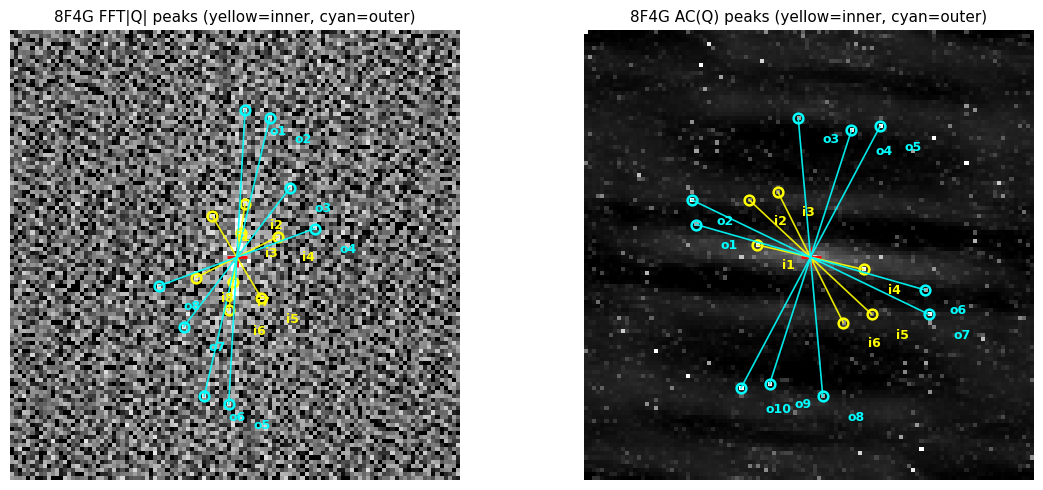

Saved: /content/geometry_fft_ac_two_rings/TWO_RING_GEOM_8F4G.png

==== 8F4H ====
FFT:
  inner ring: n=2  r_mean=5.00  r_cv=0.0000
    r(px)  : [5.0, 5.0]
    θ(deg) : [0.0, 180.0]
    Δθ(deg): [180.0, 180.0]
  outer ring: n=2  r_mean=6.00  r_cv=0.0000
    r(px)  : [6.0, 6.0]
    θ(deg) : [-90.0, 90.0]
    Δθ(deg): [180.0, 180.0]
AC:
  inner ring: n=6  r_mean=15.13  r_cv=0.4193
    r(px)  : [21.0, 6.3, 18.0, 21.0, 6.3, 18.0]
    θ(deg) : [-177.3, -161.6, -160.6, 2.7, 18.4, 19.4]
    Δθ(deg): [15.7, 1.0, 163.3, 15.7, 1.0, 163.3]
  outer ring: n=4  r_mean=33.51  r_cv=0.0149
    r(px)  : [33.0, 34.0, 33.0, 34.0]
    θ(deg) : [-91.7, -24.3, 88.3, 155.7]
    Δθ(deg): [67.4, 112.6, 67.4, 112.6]


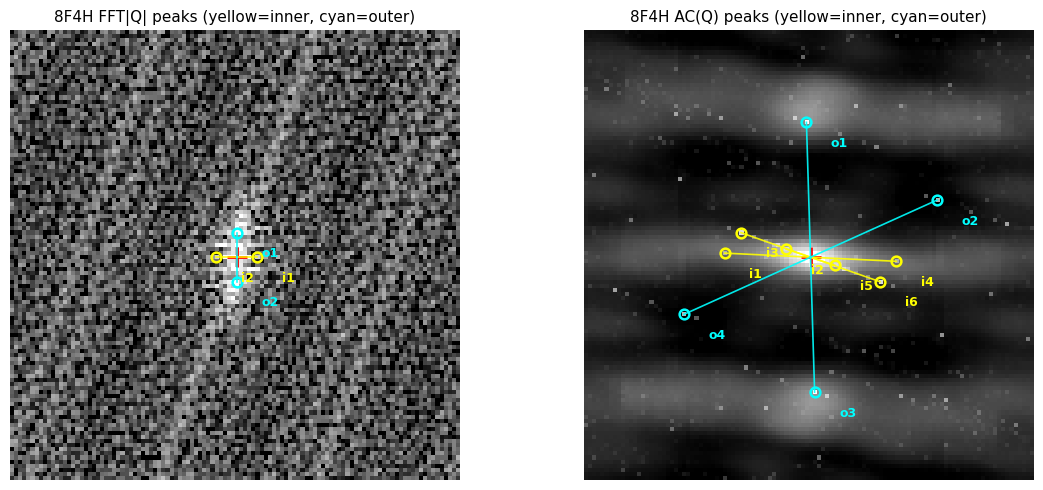

Saved: /content/geometry_fft_ac_two_rings/TWO_RING_GEOM_8F4H.png

==== 8F4I ====
FFT:
  inner ring: n=4  r_mean=10.02  r_cv=0.5008
    r(px)  : [5.0, 15.0, 5.0, 15.0]
    θ(deg) : [-90.0, -86.2, 90.0, 93.8]
    Δθ(deg): [3.8, 176.2, 3.8, 176.2]
  outer ring: n=4  r_mean=28.19  r_cv=0.2189
    r(px)  : [34.4, 22.0, 34.4, 22.0]
    θ(deg) : [-98.4, -87.4, 81.6, 92.6]
    Δθ(deg): [11.0, 169.0, 11.0, 169.0]
AC:
  inner ring: n=10  r_mean=14.01  r_cv=0.3751
    r(px)  : [14.0, 19.1, 10.8, 20.1, 6.0, 14.0, 19.1, 10.8, 20.1, 6.0]
    θ(deg) : [-175.9, -132.9, -68.2, -26.6, 0.0, 4.1, 47.1, 111.8, 153.4, 180.0]
    Δθ(deg): [43.0, 64.7, 41.6, 26.6, 4.1, 43.0, 64.7, 41.6, 26.6, 4.1]
  outer ring: n=4  r_mean=34.63  r_cv=0.0932
    r(px)  : [31.4, 37.9, 31.4, 37.9]
    θ(deg) : [-170.8, -167.8, 9.2, 12.2]
    Δθ(deg): [3.0, 177.0, 3.0, 177.0]


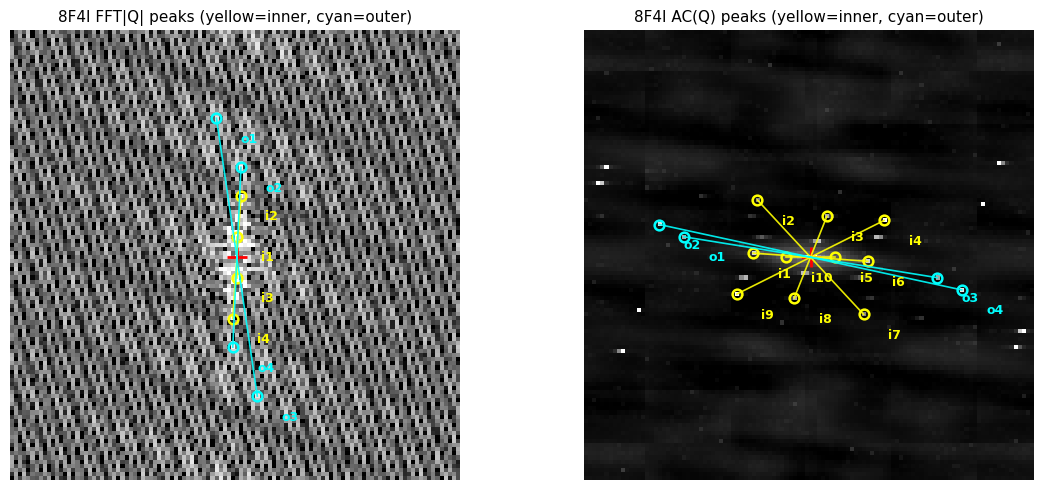

Saved: /content/geometry_fft_ac_two_rings/TWO_RING_GEOM_8F4I.png

==== 8F4J ====
FFT:
  inner ring: n=2  r_mean=6.00  r_cv=0.0000
    r(px)  : [6.0, 6.0]
    θ(deg) : [-90.0, 90.0]
    Δθ(deg): [180.0, 180.0]
  outer ring: n=2  r_mean=15.03  r_cv=0.0000
    r(px)  : [15.0, 15.0]
    θ(deg) : [-86.2, 93.8]
    Δθ(deg): [180.0, 180.0]
AC:
  inner ring: n=2  r_mean=6.00  r_cv=0.0000
    r(px)  : [6.0, 6.0]
    θ(deg) : [0.0, 180.0]
    Δθ(deg): [180.0, 180.0]
  outer ring: n=2  r_mean=12.04  r_cv=0.0000
    r(px)  : [12.0, 12.0]
    θ(deg) : [-175.2, 4.8]
    Δθ(deg): [180.0, 180.0]


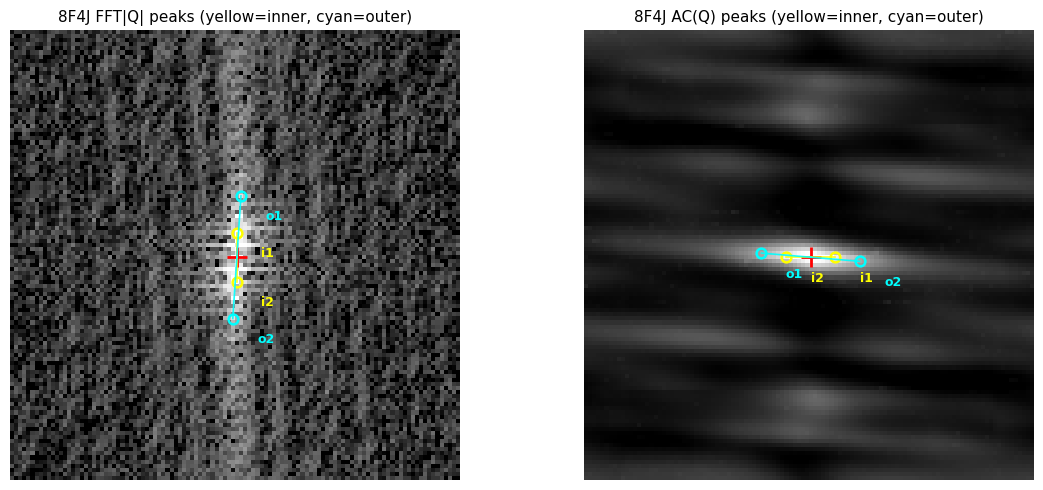

Saved: /content/geometry_fft_ac_two_rings/TWO_RING_GEOM_8F4J.png

All saved to: /content/geometry_fft_ac_two_rings


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# ONE BLOCK (no forced symmetry):
# For each dataset G/H/I/J, for BOTH FFT|Q| and AC(Q),
#   1) find MANY local maxima in an annulus (NOT 6 lobes on one ring),
#   2) split them into TWO radial families ("inner ring" + "outer ring"),
#   3) within each ring, keep top peaks by strength (no +/- pairing),
#   4) draw circles+rays and print school geometry (r, θ, Δθ).
# This will preserve the asymmetries you saw by eye.
# ============================================================

BASE = Path("/content/drive/MyDrive/dj_maps_8F4_MEDIUM")
FILES = {
    "G": BASE / "DJ_8F4G_g_gamma_Q_kappa_MEDIUM.npz",
    "H": BASE / "DJ_8F4H_g_gamma_Q_kappa_MEDIUM.npz",
    "I": BASE / "DJ_8F4I_g_gamma_Q_kappa_MEDIUM.npz",
    "J": BASE / "DJ_8F4J_g_gamma_Q_kappa_MEDIUM.npz",
}
OUTDIR = Path("/content/geometry_fft_ac_two_rings")
OUTDIR.mkdir(parents=True, exist_ok=True)

# --- where to look (as fraction of min(ny,nx)) ---
RMIN_FRAC = 0.04
RMAX_FRAC = 0.35

# --- peak detection controls ---
# (increase PEAK_PCT to be stricter; increase MIN_SEP_PX to reduce duplicates)
PEAK_PCT = 99.2
MIN_SEP_PX = 6

# --- how many peaks per ring to report/draw (no requirement it be 6) ---
TOPK_PER_RING = 10

# --- display lens ---
FFT_VMIN_PCT = 10.0
FFT_VMAX_PCT = 99.8
AC_VMIN_PCT  = 5.0
AC_VMAX_PCT  = 99.9

def load_q(path: Path) -> np.ndarray:
    d = np.load(path, allow_pickle=True)
    q = d["Q_grid"].astype(float).copy()
    q[~np.isfinite(q)] = np.nanmean(q)
    return q

def fft_mag(q: np.ndarray) -> np.ndarray:
    F = np.fft.fftshift(np.fft.fft2(q))
    return np.abs(F) + 1e-12

def autocorr(q: np.ndarray) -> np.ndarray:
    P = np.abs(np.fft.fft2(q))**2
    ac = np.fft.ifft2(P).real
    return np.fft.fftshift(ac)

def polar_grid(shape):
    ny, nx = shape
    cy, cx = ny // 2, nx // 2
    yy, xx = np.indices(shape)
    dx = xx - cx
    dy = yy - cy
    r = np.sqrt(dx*dx + dy*dy)
    th = np.degrees(np.arctan2(dy, dx))  # [-180, 180]
    return (cx, cy), r, th

def annulus_mask(r, rmin_frac, rmax_frac):
    rmin = rmin_frac * min(r.shape)
    rmax = rmax_frac * min(r.shape)
    return (r >= rmin) & (r <= rmax), rmin, rmax

def find_local_maxima(A, mask, min_sep_px=6, peak_pct=99.0, suppress_center_r=None, center_xy=None):
    """
    Return list of peaks: (val, px, py, r, theta_deg)
    Uses a simple greedy non-maximum suppression:
      - take candidates above percentile threshold
      - repeatedly take strongest remaining, then suppress a disk around it
    This does NOT enforce +/- pairing.
    """
    A2 = A.copy()

    if suppress_center_r is not None and center_xy is not None:
        cx, cy = center_xy
        yy, xx = np.indices(A2.shape)
        rr = np.sqrt((xx-cx)**2 + (yy-cy)**2)
        A2[rr < suppress_center_r] = 0.0

    A2[~mask] = 0.0
    vals = A2[mask]
    if vals.size == 0:
        return []

    thr = np.percentile(vals, peak_pct)
    cand = np.argwhere((A2 >= thr) & mask)
    if cand.size == 0:
        return []

    # Sort candidate coordinates by value descending
    cand_vals = A2[cand[:,0], cand[:,1]]
    order = np.argsort(cand_vals)[::-1]
    cand = cand[order]

    peaks = []
    suppressed = np.zeros_like(A2, dtype=bool)

    yy, xx = np.indices(A2.shape)
    for (py, px) in cand:
        if suppressed[py, px]:
            continue
        v = float(A2[py, px])
        if v <= 0:
            break
        peaks.append((v, int(px), int(py)))
        # suppress a disk around this peak
        rr = (xx - px)**2 + (yy - py)**2
        suppressed |= (rr <= (min_sep_px**2))

    return peaks

def split_two_rings(peaks, center_xy):
    """
    peaks: list of (val, px, py)
    returns: ringA, ringB lists with attached (val, px, py, r, theta)
    Splits by radius using a 1D 2-means (k=2) on radii.
    If radii are unimodal, the split will still happen but may be weak.
    """
    cx, cy = center_xy
    if len(peaks) == 0:
        return [], []

    data = []
    for v, px, py in peaks:
        dx = px - cx
        dy = py - cy
        r = float(np.hypot(dx, dy))
        th = float(np.degrees(np.arctan2(dy, dx)))
        data.append((v, px, py, r, th))

    radii = np.array([d[3] for d in data], float)

    # initialize two centroids at 25th and 75th percentiles
    c1 = float(np.percentile(radii, 25))
    c2 = float(np.percentile(radii, 75))
    if abs(c2 - c1) < 1e-6:
        # no spread
        return data, []

    # 2-means iterations
    for _ in range(30):
        d1 = np.abs(radii - c1)
        d2 = np.abs(radii - c2)
        lab = (d2 < d1).astype(int)
        if np.all(lab == 0) or np.all(lab == 1):
            break
        nc1 = float(np.mean(radii[lab == 0]))
        nc2 = float(np.mean(radii[lab == 1]))
        if abs(nc1 - c1) < 1e-6 and abs(nc2 - c2) < 1e-6:
            break
        c1, c2 = nc1, nc2

    ring0 = [data[i] for i in range(len(data)) if lab[i] == 0]
    ring1 = [data[i] for i in range(len(data)) if lab[i] == 1]

    # label inner vs outer by mean radius
    if len(ring0) == 0:
        return [], ring1
    if len(ring1) == 0:
        return ring0, []
    if np.mean([x[3] for x in ring0]) <= np.mean([x[3] for x in ring1]):
        inner, outer = ring0, ring1
    else:
        inner, outer = ring1, ring0

    return inner, outer

def geometry_from_points(points):
    """
    points: list of (val, px, py, r, theta_deg)
    Returns sorted by theta and provides r, theta, dtheta.
    """
    if len(points) == 0:
        return [], np.array([]), np.array([]), np.array([])
    pts = sorted(points, key=lambda t: t[4])
    r = np.array([p[3] for p in pts], float)
    th = np.array([p[4] for p in pts], float)

    if len(th) >= 2:
        th2 = np.concatenate([th, [th[0] + 360.0]])
        dth = np.diff(th2)
    else:
        dth = np.array([])

    return pts, r, th, dth

def draw_panel(ax, img, title, center_xy, pts_inner, pts_outer, is_fft=True):
    cx, cy = center_xy

    if is_fft:
        vmin = np.percentile(img, FFT_VMIN_PCT)
        vmax = np.percentile(img, FFT_VMAX_PCT)
        ax.imshow(np.log10(img), cmap="gray",
                  vmin=np.log10(vmin), vmax=np.log10(vmax),
                  interpolation="nearest")
    else:
        lo = np.percentile(img, AC_VMIN_PCT)
        hi = np.percentile(img, AC_VMAX_PCT)
        ax.imshow(img, cmap="gray", vmin=lo, vmax=hi, interpolation="nearest")

    ax.plot(cx, cy, "r+", ms=14, mew=2)

    # helper to draw points/rays
    def draw_pts(pts, color, label_prefix):
        for i, (v, px, py, r, th) in enumerate(pts, start=1):
            ax.plot(px, py, "o", ms=7, mfc="none", mew=1.8, color=color)
            ax.plot([cx, px], [cy, py], "-", lw=1.2, color=color, alpha=0.9)
            ax.text(px + 6, py + 6, f"{label_prefix}{i}", color=color, fontsize=9, weight="bold")

    draw_pts(pts_inner, "yellow", "i")
    draw_pts(pts_outer, "cyan", "o")

    ax.set_title(title, fontsize=11)
    ax.axis("off")

def print_geom(tag, pts, r, th, dth):
    if len(pts) == 0:
        print(f"  {tag}: (no peaks)")
        return
    r_cv = float(np.std(r) / (np.mean(r) + 1e-12)) if len(r) > 1 else 0.0
    print(f"  {tag}: n={len(pts)}  r_mean={np.mean(r):.2f}  r_cv={r_cv:.4f}")
    print(f"    r(px)  : {[round(x,1) for x in r.tolist()]}")
    print(f"    θ(deg) : {[round(x,1) for x in th.tolist()]}")
    if dth.size:
        print(f"    Δθ(deg): {[round(x,1) for x in dth.tolist()]}")
    else:
        print(f"    Δθ(deg): []")

# ============================
# RUN
# ============================
for k, path in FILES.items():
    q = load_q(path)
    M = fft_mag(q)
    AC = autocorr(q)

    # FFT peaks
    ctrF, rF, thF = polar_grid(M.shape)
    maskF, rminF, rmaxF = annulus_mask(rF, RMIN_FRAC, RMAX_FRAC)
    peaksF = find_local_maxima(M, maskF, min_sep_px=MIN_SEP_PX, peak_pct=PEAK_PCT,
                               suppress_center_r=None, center_xy=ctrF)
    innerF, outerF = split_two_rings(peaksF, ctrF)
    innerF = sorted(innerF, key=lambda t: t[0], reverse=True)[:TOPK_PER_RING]
    outerF = sorted(outerF, key=lambda t: t[0], reverse=True)[:TOPK_PER_RING]
    ptsFi, rFi, aFi, dFi = geometry_from_points(innerF)
    ptsFo, rFo, aFo, dFo = geometry_from_points(outerF)

    # AC peaks (suppress central blob)
    ctrA, rA, thA = polar_grid(AC.shape)
    maskA, rminA, rmaxA = annulus_mask(rA, RMIN_FRAC, RMAX_FRAC)
    suppress_center = 0.05 * min(AC.shape)  # avoid the AC centre blob
    peaksA = find_local_maxima(AC, maskA, min_sep_px=MIN_SEP_PX, peak_pct=PEAK_PCT,
                               suppress_center_r=suppress_center, center_xy=ctrA)
    innerA, outerA = split_two_rings(peaksA, ctrA)
    innerA = sorted(innerA, key=lambda t: t[0], reverse=True)[:TOPK_PER_RING]
    outerA = sorted(outerA, key=lambda t: t[0], reverse=True)[:TOPK_PER_RING]
    ptsAi, rAi, aAi, dAi = geometry_from_points(innerA)
    ptsAo, rAo, aAo, dAo = geometry_from_points(outerA)

    # Print "school geometry" (NO forced symmetry)
    print(f"\n==== 8F4{k} ====")
    print("FFT:")
    print_geom("inner ring", ptsFi, rFi, aFi, dFi)
    print_geom("outer ring", ptsFo, rFo, aFo, dFo)
    print("AC:")
    print_geom("inner ring", ptsAi, rAi, aAi, dAi)
    print_geom("outer ring", ptsAo, rAo, aAo, dAo)

    # Draw
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    draw_panel(axs[0], M,  f"8F4{k} FFT|Q| peaks (yellow=inner, cyan=outer)", ctrF, ptsFi, ptsFo, is_fft=True)
    draw_panel(axs[1], AC, f"8F4{k} AC(Q) peaks (yellow=inner, cyan=outer)",  ctrA, ptsAi, ptsAo, is_fft=False)
    out = OUTDIR / f"TWO_RING_GEOM_8F4{k}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.show()
    print("Saved:", out)

print("\nAll saved to:", OUTDIR)

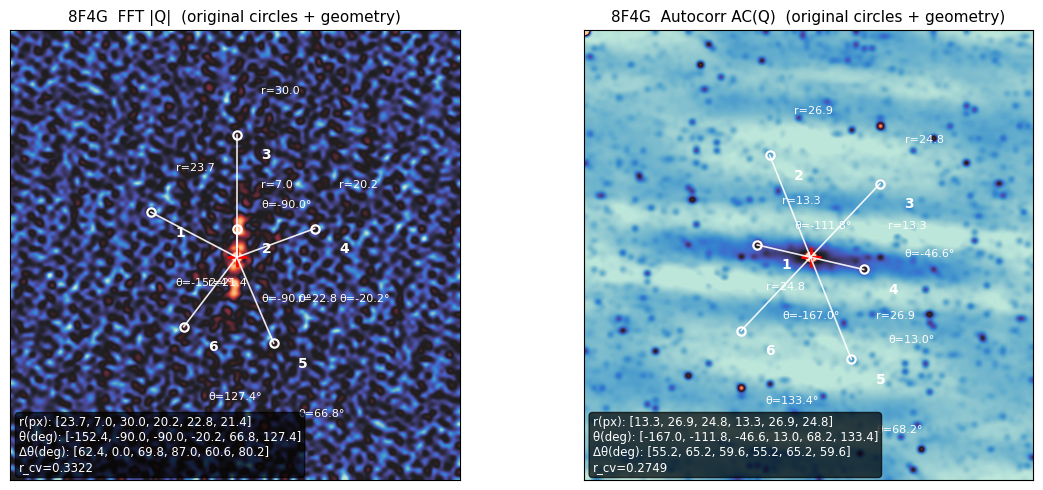


8F4G
  FFT: r_cv=0.3322  Δθ=[62.4, 0.0, 69.8, 87.0, 60.6, 80.2]
   AC: r_cv=0.2749  Δθ=[55.2, 65.2, 59.6, 55.2, 65.2, 59.6]
Saved: /content/original_circles_with_geometry/ORIGINAL_CIRCLES_GEOM_8F4G.png


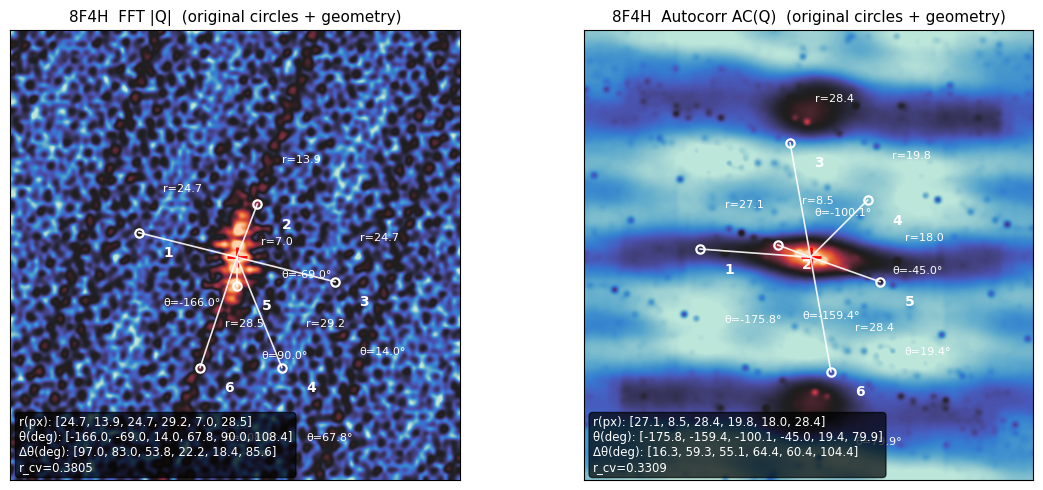


8F4H
  FFT: r_cv=0.3805  Δθ=[97.0, 83.0, 53.8, 22.2, 18.4, 85.6]
   AC: r_cv=0.3309  Δθ=[16.3, 59.3, 55.1, 64.4, 60.4, 104.4]
Saved: /content/original_circles_with_geometry/ORIGINAL_CIRCLES_GEOM_8F4H.png


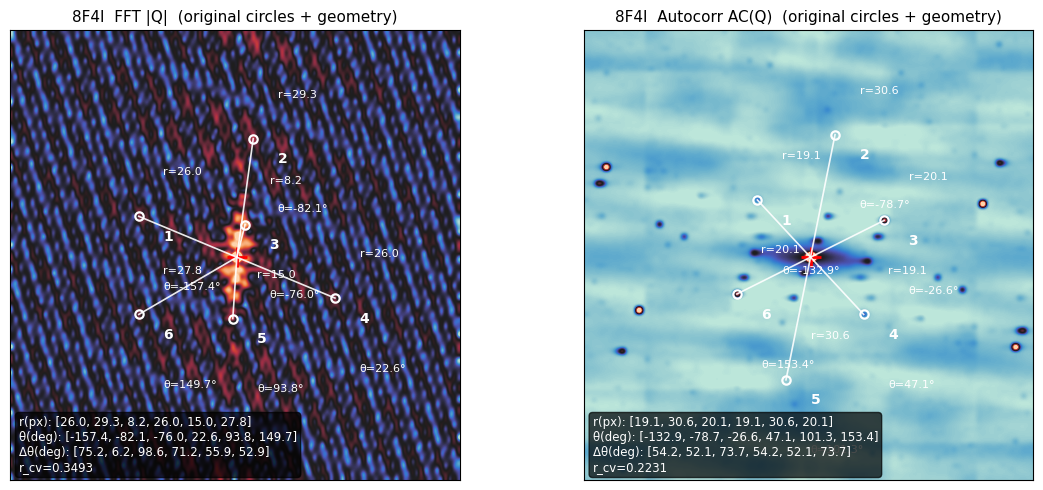


8F4I
  FFT: r_cv=0.3493  Δθ=[75.2, 6.2, 98.6, 71.2, 55.9, 52.9]
   AC: r_cv=0.2231  Δθ=[54.2, 52.1, 73.7, 54.2, 52.1, 73.7]
Saved: /content/original_circles_with_geometry/ORIGINAL_CIRCLES_GEOM_8F4I.png


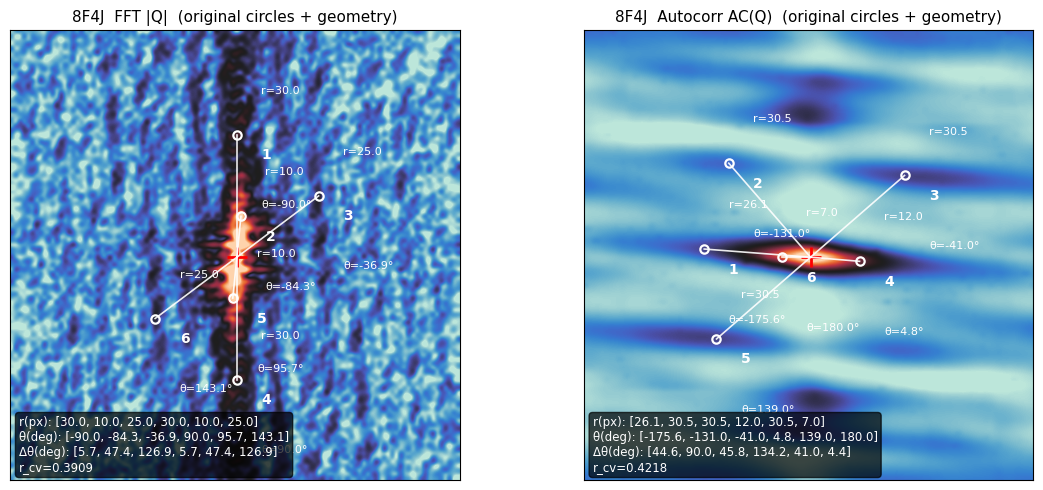


8F4J
  FFT: r_cv=0.3909  Δθ=[5.7, 47.4, 126.9, 5.7, 47.4, 126.9]
   AC: r_cv=0.4218  Δθ=[44.6, 90.0, 45.8, 134.2, 41.0, 4.4]
Saved: /content/original_circles_with_geometry/ORIGINAL_CIRCLES_GEOM_8F4J.png

All saved to: /content/original_circles_with_geometry


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path

# =========================
# CONFIG (matches the original “small circle” peak logic)
# =========================
BASE = Path("/content/drive/MyDrive/dj_maps_8F4_MEDIUM")
FILES = {
    "G": BASE / "DJ_8F4G_g_gamma_Q_kappa_MEDIUM.npz",
    "H": BASE / "DJ_8F4H_g_gamma_Q_kappa_MEDIUM.npz",
    "I": BASE / "DJ_8F4I_g_gamma_Q_kappa_MEDIUM.npz",
    "J": BASE / "DJ_8F4J_g_gamma_Q_kappa_MEDIUM.npz",
}
OUTDIR = Path("/content/original_circles_with_geometry")
OUTDIR.mkdir(parents=True, exist_ok=True)

ANNULUS_R_MIN_FRAC = 0.06
ANNULUS_R_MAX_FRAC = 0.28
PEAK_EXCLUSION = 18

# display lens similar to your “hex-visible” plots
FFT_VMIN_PCT = 10.0
FFT_VMAX_PCT = 99.8
AC_VMIN_PCT  = 5.0
AC_VMAX_PCT  = 99.9

def get_icefire():
    try:
        return plt.colormaps["icefire"]
    except Exception:
        try:
            import seaborn as sns
            return sns.color_palette("icefire", as_cmap=True)
        except Exception:
            return "inferno"

CMAP = get_icefire()

# =========================
# Helpers
# =========================
def load_q(npz_path: Path) -> np.ndarray:
    d = np.load(npz_path, allow_pickle=True)
    q = d["Q_grid"].astype(float).copy()
    q[~np.isfinite(q)] = np.nanmean(q)
    return q

def fft2_shift(q: np.ndarray) -> np.ndarray:
    return np.fft.fftshift(np.fft.fft2(q))

def fft_mag(F: np.ndarray) -> np.ndarray:
    return np.abs(F) + 1e-12

def autocorr(q: np.ndarray) -> np.ndarray:
    P = np.abs(np.fft.fft2(q)) ** 2
    ac = np.fft.ifft2(P).real
    return np.fft.fftshift(ac)

def build_annulus(shape, rmin_frac, rmax_frac):
    ny, nx = shape
    cy, cx = ny // 2, nx // 2
    yy, xx = np.indices((ny, nx))
    rr = np.sqrt((yy - cy) ** 2 + (xx - cx) ** 2)
    rmin = rmin_frac * min(ny, nx)
    rmax = rmax_frac * min(ny, nx)
    ann = (rr >= rmin) & (rr <= rmax)
    return ann, rr, (cy, cx), (rmin, rmax)

def pick_peaks_in_mask(M: np.ndarray, mask: np.ndarray, n=6, exclusion=18):
    ny, nx = M.shape
    work = M.copy()
    work[~mask] = 0.0
    peaks = []
    for _ in range(n):
        idx = np.argmax(work)
        py, px = np.unravel_index(idx, work.shape)
        peaks.append((py, px, M[py, px]))
        y0 = max(0, py - exclusion)
        y1 = min(ny, py + exclusion + 1)
        x0 = max(0, px - exclusion)
        x1 = min(nx, px + exclusion + 1)
        work[y0:y1, x0:x1] = 0.0
    return peaks

def find_ac_secondary_peaks(ac: np.ndarray, rr: np.ndarray, center_yx, rmin, rmax, n=6, exclusion=18):
    cy, cx = center_yx
    ann = (rr >= rmin) & (rr <= rmax)
    work = ac.copy()
    work[~ann] = 0.0
    work[(rr < (0.03 * min(ac.shape)))] = 0.0  # suppress centre blob
    return pick_peaks_in_mask(work, ann, n=n, exclusion=exclusion)

def geom_from_peaks(peaks_yx, center_yx):
    cy, cx = center_yx
    rays = []
    for (py, px) in peaks_yx:
        dx = px - cx
        dy = py - cy
        r = float(np.hypot(dx, dy))
        th = float(np.degrees(np.arctan2(dy, dx)))  # [-180, 180]
        rays.append((r, th, py, px))
    # sort by angle
    rays.sort(key=lambda t: t[1])
    r = np.array([t[0] for t in rays], float)
    th = np.array([t[1] for t in rays], float)
    th2 = np.concatenate([th, [th[0] + 360.0]])
    dth = np.diff(th2)
    return rays, r, th, dth

def annotate_panel(ax, img, title, center_yx, peaks_yx, is_fft=True):
    cy, cx = center_yx

    if is_fft:
        ann, _, _, _ = build_annulus(img.shape, ANNULUS_R_MIN_FRAC, ANNULUS_R_MAX_FRAC)
        vmin = np.percentile(img[ann], FFT_VMIN_PCT)
        vmax = np.percentile(img[ann], FFT_VMAX_PCT)
        ax.imshow(img, cmap=CMAP, norm=LogNorm(vmin=vmin, vmax=vmax), interpolation="bicubic")
    else:
        lo = np.percentile(img, AC_VMIN_PCT)
        hi = np.percentile(img, AC_VMAX_PCT)
        ax.imshow(img, cmap=CMAP, vmin=lo, vmax=hi, interpolation="bicubic")

    # centre
    ax.plot(cx, cy, "r+", ms=14, mew=2)

    # geometry
    rays, r, th, dth = geom_from_peaks(peaks_yx, center_yx)

    # draw circles + rays + labels
    for i, (ri, thi, py, px) in enumerate(rays, start=1):
        ax.plot(px, py, "wo", markersize=6, markerfacecolor="none", markeredgewidth=1.6)
        ax.plot([cx, px], [cy, py], "w-", lw=1.2, alpha=0.9)
        ax.text(px + 6, py + 6, f"{i}", color="white", fontsize=10, weight="bold")
        ax.text(px + 6, py - 10, f"r={ri:.1f}", color="white", fontsize=8)
        ax.text(px + 6, py + 18, f"θ={thi:.1f}°", color="white", fontsize=8)

    # text box
    r_cv = float(np.std(r) / (np.mean(r) + 1e-12)) if len(r) > 1 else 0.0
    txt = (
        f"r(px): {[round(x,1) for x in r.tolist()]}\n"
        f"θ(deg): {[round(x,1) for x in th.tolist()]}\n"
        f"Δθ(deg): {[round(x,1) for x in dth.tolist()]}\n"
        f"r_cv={r_cv:.4f}"
    )
    ax.set_title(title, fontsize=11)
    ax.text(
        0.02, 0.02, txt, transform=ax.transAxes,
        fontsize=8.5, color="white",
        bbox=dict(boxstyle="round", facecolor="black", alpha=0.7)
    )
    ax.set_xticks([]); ax.set_yticks([])

    return r, th, dth, r_cv

# =========================
# RUN (G/H/I/J) — FFT + AC in one figure each
# =========================
for k, path in FILES.items():
    q = load_q(path)

    # FFT
    F = fft2_shift(q)
    M = fft_mag(F)
    ann, rr, ctr, (rmin, rmax) = build_annulus(M.shape, ANNULUS_R_MIN_FRAC, ANNULUS_R_MAX_FRAC)
    peaks_fft = pick_peaks_in_mask(M, ann, n=6, exclusion=PEAK_EXCLUSION)
    peaks_fft_yx = [(py, px) for (py, px, _) in peaks_fft]

    # AC
    ac = autocorr(q)
    peaks_ac = find_ac_secondary_peaks(ac, rr, ctr, rmin, rmax, n=6, exclusion=PEAK_EXCLUSION)
    peaks_ac_yx = [(py, px) for (py, px, _) in peaks_ac]

    # figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    rF, thF, dF, rcvF = annotate_panel(
        axs[0], M, f"8F4{k}  FFT |Q|  (original circles + geometry)", ctr, peaks_fft_yx, is_fft=True
    )
    rA, thA, dA, rcvA = annotate_panel(
        axs[1], ac, f"8F4{k}  Autocorr AC(Q)  (original circles + geometry)", ctr, peaks_ac_yx, is_fft=False
    )

    out_png = OUTDIR / f"ORIGINAL_CIRCLES_GEOM_8F4{k}.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.show()

    print(f"\n8F4{k}")
    print(f"  FFT: r_cv={rcvF:.4f}  Δθ={ [round(x,1) for x in dF.tolist()] }")
    print(f"   AC: r_cv={rcvA:.4f}  Δθ={ [round(x,1) for x in dA.tolist()] }")
    print("Saved:", out_png)

print("\nAll saved to:", OUTDIR)